In [1]:
from moist_konrad import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%time
#### PRECIPITATION TEST
heat_sink = 0.
E_imbalance = 0.
opacity = 66.
albedo = 0.2

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=0,
    depth = 50,
    albedo = 0.5)

print(surface.albedo)
surface.albedo = albedo
print(surface.albedo)

radiation = konrad.radiation.RRTMG(solar_constant=551.58-opacity)

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
T_atm_low = surface['temperature'].copy()

ndays = 15000
timestep = 0.5 #days
nsteps = int(ndays/timestep)

printcounter = 0
status = 0

tol = 1e-5

dE_1 = [1e8]
OLR_1 = [1e8]
NSW_1 = [1e8]
T_sfc_1 = [1e8]
toa_1 = [1e8]
T_low_1 = [1e8]

#### RCE FOR PRESENT-DAY CO2
atmosphere['CO2'][0] = 348/1e6
for i in range(nsteps):
    
    #surface fluxes
    z = height(atmosphere['plev'],atmosphere['T'][0].copy(),
               atmosphere['phlev'][0],surface['temperature'].copy())
    zini = 2
    
    T_ini,vmr_ini = T_vmr_z(T_atm_low,atmosphere['T'][0][0].copy(),
                            atmosphere['H2O'][0,0].copy(),atmosphere['H2O'][0,1].copy(),
                            z,zini)
    
    LH = latent_heat(vmr_ini, T_ini,atmosphere['phlev'][0])
    SH = sensible_heat(T_ini,surface['temperature'].copy(),atmosphere['phlev'][0])/40
    
    #convective adjustment of the armosphere
    atmosphere,surface,radiation,net_rad_surface,atm_rad,\
    T_atm_low,E_imbalance,prec_mass,RH,cold_point,conv_top = RCPE_step(timestep,
                                                                          atmosphere,surface,radiation,clearsky,
                                                                          SH,LH,albedo,
                                                                          conv_top,
                                                                      strong_coupling = False,
                                                                      constrain_RH = True)
    
        
    print(E_imbalance,T_atm_low,surface['temperature'])
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - SH - LH)
                               * seconds_day * timestep / surface.heat_capacity)
    
    
    
    status += 1
    if printcounter == 200:
        print(status/2)
        printcounter = 0
        print(surface['temperature'],SH,LH,prec_mass*Lv/seconds_day/timestep,
              E_imbalance,np.maximum(0.,np.minimum(1.,LH/(LH+SH))))
        print(RH[0])
        print(T_atm_low)
    printcounter += 1

    
    dE_1.append(E_imbalance.copy())
    OLR_1.append(radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy())
    NSW_1.append(radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy())
    T_sfc_1.append(surface['temperature'].copy())
    toa_1.append(radiation['toa'].copy())
    T_low_1.append(T_ini.copy())
    
    if abs(T_sfc_1[i]-T_sfc_1[i-1])<tol and abs(toa_1[i]-toa_1[i-1])<tol:
        print(i)
        break
    
    
### Record RCE 1xCO2
RH_1 = RH.copy()
Mw_1 = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']).copy()
vmr_1 = atmosphere['H2O'][0].copy()
T_atm_1 = atmosphere['T'][0].copy()
SH_1 = SH.copy()
LH_1 = LH.copy()
Prec_1 = prec_mass.copy()/timestep
atm_rad_1 = atm_rad.copy()
sfc_rad_1 = net_rad_surface.copy()

0.5
0.2
[57193336.62600279] [-3388799.83991194]
[-0.00107976] [287.29403788] [288.]
[58755848.62361908] [-3001016.50216675]
[-0.00098375] [287.30663483] [288.01344555]
[60130985.13910723] [-3148540.55268955]
[-0.00076059] [287.30449155] [288.02305432]
[61290090.68823147] [-3379949.13733721]
[-0.00141755] [287.30862224] [288.03350864]
[62329268.66765928] [-3509965.39113092]
[-0.00074206] [287.30922839] [288.04445716]
[63249942.84688616] [-3631136.86255312]
[-0.001683] [287.30811743] [288.0554944]
[64056595.55890703] [-3744924.56135988]
[-0.00084532] [287.30645818] [288.06644744]
[64754751.37783289] [-3850976.02296543]
[-0.00224744] [287.30574869] [288.0771901]
[65352340.80449152] [-3947752.3446722]
[-0.00119073] [287.30777301] [288.08763204]
[65858326.6635685] [-4035198.52430439]
[-0.00118814] [287.31081808] [288.09771032]
[66332825.68298388] [-4061941.85989046]
[-0.00057578] [287.31170554] [288.10738441]
[66730343.65224981] [-4134062.0995965]
[-0.0006127] [287.31522405] [288.11663627]


[-0.00037811] [287.82306006] [288.58403379]
[73268890.34285545] [-4693925.40793848]
[-0.00038546] [287.82910755] [288.58847085]
[73282850.45712852] [-4695902.17023802]
[-0.00039349] [287.83515911] [288.59289873]
[73296159.87242079] [-4697864.07811546]
[-0.0004014] [287.84121458] [288.59731754]
[73308880.25325632] [-4699768.38280439]
[-0.00040939] [287.84727361] [288.60172719]
[73320956.03268337] [-4701699.53254414]
[-0.00041768] [287.85333792] [288.60612819]
[73332434.89080858] [-4703729.17098379]
[-0.00042622] [287.85940784] [288.61052058]
[73343315.9611392] [-4705771.04108]
[-0.00043423] [287.86548117] [288.61490504]
[73353609.22041273] [-4707757.22340965]
[-0.00044234] [287.87155834] [288.61928158]
[73363403.24523687] [-4709629.44261074]
[-0.00044947] [287.87763449] [288.62365034]
[73372634.71210384] [-4711552.76064777]
[-0.0004579] [287.88371645] [288.62801065]
[73381283.42557049] [-4713372.45754385]
[-0.00046622] [287.88980404] [288.63236309]
[73389425.88111305] [-4715251.02389956

[-0.00051203] [288.43384904] [288.99115044]
[72631229.27323675] [-4845694.59177542]
[-0.00051571] [288.44022173] [288.99501162]
[72611607.82261944] [-4847051.6594429]
[-0.00051891] [288.4465975] [288.99886854]
[72591749.08144283] [-4848241.03705215]
[-0.00072894] [288.45308035] [289.00272192]
100.5
[289.00657092] [6.86144372] [105.8507582] [105.36635806] [-0.00072894] [0.93912422]
0.6671850700504306
[288.45308035]
[72571677.57399702] [-4849516.69846487]
[-0.0005457] [288.45947024] [289.00657092]
[72551395.63442135] [-4850876.26295233]
[-0.00054962] [288.46586512] [289.01041589]
[72530939.1651864] [-4852110.21582794]
[-0.0004946] [288.47223428] [289.01425728]
[72510310.63708115] [-4853312.68244791]
[-0.00055615] [288.47863757] [289.01809464]
[72489471.54211807] [-4854623.54633522]
[-0.00064878] [288.48509268] [289.02192806]
[72468438.30433369] [-4855877.69477892]
[-0.00054803] [288.49150559] [289.02575783]
[72447190.5826745] [-4857238.42906237]
[-0.00055196] [288.49792257] [289.02958384

[-0.00037232] [289.0748384] [289.35258761]
[69856513.86337519] [-4966201.62625551]
[-0.00037272] [289.08164844] [289.35610992]
[69820137.68429995] [-4967603.65136909]
[-0.00037355] [289.08846532] [289.35962915]
[69783607.1714921] [-4968786.36574602]
[-0.00037404] [289.09528837] [289.36314583]
[69746921.02158594] [-4970040.2536869]
[-0.00037546] [289.10212014] [289.36665908]
[69710081.58020496] [-4971161.87609673]
[-0.00037624] [289.10895896] [289.37016912]
[69673107.43487883] [-4972414.98637056]
[-0.00037674] [289.1158028] [289.37367541]
[69635918.47046661] [-4973774.68990993]
[-0.00037813] [289.12265717] [289.37717858]
[69598661.2433443] [-4974947.34987354]
[-0.00037795] [289.1295126] [289.38067915]
[69561202.60876513] [-4976276.30303669]
[-0.00037914] [289.13637673] [289.38417627]
[69523599.01926899] [-4977497.947299]
[-0.00037946] [289.14324612] [289.38767047]
[69485869.30615187] [-4978708.87537146]
[-0.0003802] [289.15012078] [289.39116125]
[69448014.8009243] [-4979998.18935633]
[-

[-0.00029143] [289.76124165] [289.69058497]
[65900931.81318665] [-5061445.26992178]
[-0.00028346] [289.76620545] [289.69395067]
[65884549.6465807] [-5061640.40513659]
[-0.00028595] [289.77111288] [289.69732074]
[65868908.17061472] [-5061965.76494217]
[-0.00028608] [289.77596604] [289.70069569]
[65854079.25853634] [-5061938.63354588]
[-0.00028388] [289.78076118] [289.70407546]
[65839991.87092352] [-5062090.13183832]
[-0.00028402] [289.7855016] [289.70745807]
200.5
[289.71084431] [-0.77539562] [118.5249178] [117.95340793] [-0.00028402] [1.]
0.6567381088904649
[289.7855016]
[65826626.06041431] [-5062142.81516743]
[-0.00028171] [289.79018808] [289.71084431]
[65813945.70854044] [-5062179.96436024]
[-0.00028059] [289.79482234] [289.71423309]
[65801914.56890726] [-5062336.1879735]
[-0.00027868] [289.79940921] [289.71762442]
[65790506.82845545] [-5062619.14351559]
[-0.00027859] [289.80395121] [289.72101876]
[65779683.31056404] [-5062955.91842318]
[-0.00028203] [289.80844998] [289.72441611]
[65

[-0.00029732] [290.13316153] [290.02079389]
[65721065.43212032] [-5100629.73081684]
[-0.00029731] [290.13661354] [290.02416488]
[65722863.35001755] [-5101037.62035942]
[-0.00029748] [290.14006252] [290.02753531]
[65724888.93380547] [-5101569.52817583]
[-0.00029761] [290.14350972] [290.03090426]
[65727726.23829556] [-5102121.17340374]
[-0.00029786] [290.14695333] [290.03427227]
[65730433.54298639] [-5102712.50755596]
[-0.00029905] [290.15040268] [290.03763946]
[65733133.3231082] [-5103145.438025]
[-0.0002993] [290.1538489] [290.04100594]
[65735831.80404997] [-5103669.0917201]
[-0.00029968] [290.15729259] [290.04437062]
[65740327.84103251] [-5104043.22838068]
[-0.00030044] [290.16073294] [290.04773417]
[65742904.04936981] [-5104621.77528572]
[-0.00030105] [290.16417363] [290.05109568]
[65745472.65842056] [-5105123.77280855]
[-0.00030154] [290.16761349] [290.05445626]
[65748075.54495907] [-5105476.13149786]
[-0.0002972] [290.1710505] [290.05781575]
[65750776.27200127] [-5106059.13210583]


[-0.00033249] [290.46762851] [290.34858034]
[65990456.1478982] [-5150342.10691738]
[-0.00033279] [290.47093828] [290.35182902]
[65993163.44776011] [-5151015.44058657]
[-0.00033356] [290.47425029] [290.35507596]
[65995901.66281033] [-5151470.72007084]
[-0.00033425] [290.47756188] [290.35832231]
[65998648.97997141] [-5151899.53098965]
[-0.00033461] [290.48087157] [290.36156718]
[66001376.25885057] [-5152496.61432695]
[-0.0003351] [290.48418014] [290.36481052]
[66004089.38175392] [-5153048.99697447]
[-0.00033553] [290.48748802] [290.36805299]
[66006835.15810394] [-5153498.42088699]
[-0.00033555] [290.49079093] [290.37129417]
[66009589.69560051] [-5153902.89797163]
[-0.00033588] [290.4940925] [290.37453377]
[66012339.44480228] [-5154461.56433868]
[-0.00033612] [290.49739191] [290.3777718]
300.5
[290.38100877] [-1.29346841] [121.01625802] [120.60970832] [-0.00033612] [1.]
0.6638778788376433
[290.49739191]
[66015095.98877192] [-5154981.55372047]
[-0.00033636] [290.50068867] [290.38100877]
[6

[-0.00037748] [290.78309578] [290.65794932]
[66248678.26853371] [-5198980.1357379]
[-0.00037733] [290.78628376] [290.66107969]
[66251323.77567768] [-5199471.48282719]
[-0.00037738] [290.78946804] [290.66420886]
[66253914.10590076] [-5200041.51955128]
[-0.00037823] [290.79265468] [290.66733675]
[66256526.0710392] [-5200438.96020508]
[-0.00037905] [290.7958415] [290.67046359]
[66259109.25535011] [-5200946.322505]
[-0.00037956] [290.799028] [290.67358882]
[66261608.01152372] [-5201585.32651186]
[-0.00038079] [290.80221866] [290.67671283]
[66264108.84107208] [-5201955.8335104]
[-0.00038127] [290.80540745] [290.6798361]
[66266625.55983162] [-5202356.34312534]
[-0.00038151] [290.80859324] [290.6829574]
[66269182.59601641] [-5202844.44834375]
[-0.000382] [290.81177681] [290.68607717]
[66271726.98219633] [-5203291.66979218]
[-0.00038239] [290.81495934] [290.68919595]
[66274295.79026651] [-5203685.08351898]
[-0.00038283] [290.81813905] [290.69231323]
[66276871.70327091] [-5204204.25784397]
[-0.

[66507794.09934092] [-5247265.97065544]
[-0.0004304] [291.09328089] [290.96205804]
[66510733.07555342] [-5247754.60184765]
[-0.00043048] [291.09634988] [290.96507153]
[66513682.31079054] [-5248140.24979353]
[-0.00043079] [291.09941627] [290.96808392]
[66516589.52848101] [-5248467.22218847]
[-0.00043169] [291.10248279] [290.97109455]
[66519413.28711271] [-5249257.93873549]
[-0.00043335] [291.10555499] [290.9741034]
[66522237.23140812] [-5249750.73477936]
[-0.00043422] [291.108627] [290.97711279]
[66525087.53842783] [-5250073.27211332]
[-0.0004347] [291.11169625] [290.98012087]
[66527957.5227747] [-5250627.94744396]
[-0.00043501] [291.11476248] [290.98312716]
[66530750.45036793] [-5251160.53340721]
[-0.00043654] [291.11783291] [290.98613265]
[66533558.86064768] [-5251571.83483601]
[-0.00043685] [291.12090015] [290.98913701]
[66536370.00398874] [-5252049.18874311]
[-0.00043718] [291.12396502] [290.99213971]
[66539229.3859992] [-5252505.83095837]
[-0.00043771] [291.12702701] [290.9951412]


[-0.00028919] [291.38578321] [291.24900529]
[66782175.32219791] [-5294096.28202724]
[-0.00028703] [291.38870149] [291.25190827]
[66785151.24175978] [-5294683.6408205]
[-0.00028575] [291.39161801] [291.25481004]
[66788151.61504507] [-5295185.45317221]
[-0.00028495] [291.39453334] [291.25771168]
[66791142.77064943] [-5295656.0529623]
[-0.00028252] [291.39744895] [291.26061232]
[66794114.40222216] [-5296048.16303921]
[-0.00028125] [291.40036412] [291.26351192]
[66797067.96851683] [-5296499.34498501]
[-0.00027997] [291.40327771] [291.26640993]
[66799882.07588673] [-5297212.14496183]
[-0.00027797] [291.40619971] [291.26930671]
[66802667.85972786] [-5297803.21978617]
[-0.00027702] [291.4091228] [291.27220332]
[66805439.04211521] [-5298287.48832321]
[-0.00027582] [291.41204513] [291.27509913]
[66808231.27689075] [-5298777.47999573]
[-0.00027317] [291.41496511] [291.27799355]
[66811009.38760471] [-5299233.98846245]
[-0.00027198] [291.41788361] [291.28088662]
[66813779.70575714] [-5299673.17141

[-0.00027444] [291.67511635] [291.53369932]
[67017764.35439348] [-5342107.97511005]
[-0.00027469] [291.67796181] [291.53648982]
[67019909.54641914] [-5342541.84951401]
[-0.00027474] [291.68080378] [291.53927913]
[67022051.4478116] [-5343069.51511192]
[-0.00073807] [291.68366909] [291.5420671]
[67024117.45521021] [-5343676.69410229]
[-0.00030586] [291.68651654] [291.5448544]
[67026189.52874374] [-5344170.47507334]
[-0.00027941] [291.68936094] [291.54764131]
[67028323.28783417] [-5344610.79507256]
[-0.00027946] [291.69220191] [291.55042703]
[67030452.32719231] [-5345053.81464481]
[-0.00027977] [291.69504113] [291.55321165]
[67032551.39497948] [-5345488.74095964]
[-0.0002802] [291.6978803] [291.5559949]
[67034623.57272577] [-5346014.608109]
[-0.00028059] [291.70071937] [291.55877697]
[67036680.58307743] [-5346735.6966114]
[-0.00028089] [291.70355775] [291.56155803]
[67038779.88203907] [-5347052.72034645]
[-0.00028112] [291.70639403] [291.56433915]
[67040882.65604973] [-5347446.77772903]
[

[-0.00033338] [291.94646189] [291.79942968]
[67216463.48897696] [-5387520.25958776]
[-0.0003343] [291.94920129] [291.80211805]
[67218460.59971046] [-5388001.00074291]
[-0.00033484] [291.9519414] [291.80480594]
[67220466.73069811] [-5388394.99588823]
[-0.00033485] [291.95467889] [291.80749273]
[67222478.97698402] [-5388823.01477718]
[-0.00030972] [291.95741492] [291.81017786]
[67224476.6869626] [-5389240.98335409]
[-0.00031004] [291.96014968] [291.81286176]
[67226467.61491871] [-5389880.52220821]
[-0.00031014] [291.96288287] [291.81554436]
[67228505.06438208] [-5390205.31793261]
[-0.00031032] [291.96561343] [291.81822681]
[67230516.45124626] [-5390680.45754337]
[-0.00031052] [291.96834313] [291.8209076]
[67232546.14801884] [-5391192.02502584]
[-0.00031051] [291.97107001] [291.82358744]
[67234585.98802471] [-5391500.47811842]
[-0.00031092] [291.97379615] [291.82626651]
[67236618.51328135] [-5392009.19747686]
[-0.00027339] [291.97649085] [291.82894393]
[67238643.48722935] [-5392559.006187

[-0.00033239] [292.2153522] [292.06315049]
[67406384.29047155] [-5433180.59199476]
[-0.00033251] [292.21799171] [292.06573655]
[67408174.8190136] [-5433648.10425329]
[-0.00033269] [292.22062969] [292.06832152]
[67409990.42992163] [-5434102.23892689]
[-0.00033276] [292.22326558] [292.0709055]
[67411844.36340857] [-5434594.96983957]
[-0.00033273] [292.22589818] [292.07348841]
[67413696.01807785] [-5434871.62099218]
[-0.0003329] [292.22852933] [292.07607039]
[67415466.540761] [-5435342.28710461]
[-0.0003342] [292.23116544] [292.07865061]
[67417166.20760536] [-5435860.97382116]
[-0.00033532] [292.23380527] [292.08123001]
[67418884.58082724] [-5436256.84658527]
[-0.00033528] [292.23644235] [292.08380876]
[67420642.21788931] [-5436804.17579603]
[-0.00033519] [292.23907599] [292.08638608]
[67422406.9495759] [-5437261.46473265]
[-0.00033544] [292.2417078] [292.08896305]
[67424161.20965385] [-5437660.35320091]
[-0.00033563] [292.2443385] [292.09153889]
[67425998.35781336] [-5438145.04434681]
[-

[-0.00038696] [292.46658717] [292.30933944]
[67609815.78301907] [-5476493.50959873]
[-0.00038892] [292.46912811] [292.3118289]
[67611943.00012875] [-5476940.9147172]
[-0.00038933] [292.47166615] [292.31431923]
[67613993.6628828] [-5477516.95783615]
[-0.00039139] [292.47420962] [292.31680822]
[67616047.92558718] [-5477821.14297867]
[-0.00039228] [292.47675199] [292.31929696]
[67618092.99396944] [-5478226.49411154]
[-0.00039298] [292.47929211] [292.32178374]
[67620130.51885128] [-5478628.08071613]
[-0.00039383] [292.4818303] [292.32426911]
[67622189.88655424] [-5478972.72485352]
[-0.00039467] [292.48436616] [292.32675302]
[67624273.27604342] [-5479371.89469099]
[-0.00039577] [292.48689992] [292.32923559]
[67626343.2985673] [-5479854.54106188]
[-0.00039696] [292.4894331] [292.33171723]
[67628405.88313198] [-5480370.95171499]
[-0.0003985] [292.49196543] [292.33419808]
[67630489.48018551] [-5480684.80430746]
[-0.00040023] [292.49449662] [292.33667838]
[67632594.25240183] [-5480999.23675871]

[-0.00043431] [292.71587495] [292.55358482]
[67810174.79744959] [-5519990.52510166]
[-0.00043411] [292.71832158] [292.5559794]
[67812100.45651007] [-5520473.73041153]
[-0.00043472] [292.72076742] [292.5583738]
[67814045.2231555] [-5520829.62406206]
[-0.00043462] [292.72321048] [292.56076723]
[67815981.88123655] [-5521267.38100386]
[-0.00043511] [292.72565207] [292.56315963]
[67817949.51188993] [-5521830.56794596]
[-0.00043501] [292.72809046] [292.56555078]
[67819960.55829] [-5522293.14486361]
[-0.00043497] [292.73052625] [292.56794165]
[67821983.53381348] [-5522695.98703003]
[-0.00043505] [292.73295923] [292.57033161]
[67823962.40793562] [-5523097.42867613]
[-0.00043584] [292.73539348] [292.57272041]
[67825966.8077488] [-5523416.32059002]
[-0.00043651] [292.73782657] [292.57510795]
[67827885.98596573] [-5523926.7710166]
[-0.00043825] [292.74026432] [292.57749427]
[67829834.9399457] [-5524230.95777655]
[-0.00043877] [292.74269999] [292.57987997]
[67831777.7653079] [-5524658.4150548]
[-0

[-0.0001976] [292.95003642] [292.78392283]
[67996275.21370077] [-5562075.59967089]
[-0.00020126] [292.95237995] [292.78622809]
[67997859.79193735] [-5562357.07227516]
[-0.00020428] [292.95472279] [292.7885325]
[67999432.65974903] [-5562758.85539627]
[-0.00023191] [292.95708913] [292.79083511]
[68001021.22648954] [-5563080.07353354]
[-0.00023478] [292.9594292] [292.79313659]
[68002617.119699] [-5563450.01242733]
[-0.00021342] [292.96176868] [292.79543665]
[68004210.79293394] [-5563810.00179911]
[-0.00021398] [292.96410684] [292.79773578]
[68005728.34764576] [-5564390.86583662]
[-0.00021479] [292.9664489] [292.8000338]
[68007269.85415554] [-5564824.20502472]
[-0.00021428] [292.96878868] [292.80233166]
[68008797.37777853] [-5565184.19086695]
[-0.00021322] [292.97112801] [292.80462865]
[68010303.31400204] [-5565659.09806347]
[-0.00021048] [292.97346704] [292.80692433]
[68011784.31781721] [-5566156.52165508]
[-0.00022013] [292.97580704] [292.80921928]
[68013299.10129786] [-5566475.4848218]


[-0.00025213] [293.18060043] [293.00990047]
[68141454.5384593] [-5603891.41537476]
[-0.00025219] [293.18286385] [293.01211643]
[68142805.64736652] [-5604137.65716219]
[-0.00025275] [293.18512624] [293.01433154]
[68143807.5984211] [-5604730.62380171]
[-0.00025257] [293.18738659] [293.01654548]
[68145174.09467697] [-5604890.79942989]
[-0.00025292] [293.1896444] [293.01875854]
[68146475.29624653] [-5605320.96902561]
[-0.00025373] [293.19190521] [293.02097021]
[68147925.67503929] [-5605868.70470381]
[-0.00025367] [293.19416345] [293.02318109]
[68149292.81178236] [-5606033.08197641]
[-0.00025405] [293.19641914] [293.02539101]
[68150744.2743845] [-5606561.26877308]
[-0.00025411] [293.19867309] [293.02759964]
[68152135.02289438] [-5606658.17963934]
[-0.00025453] [293.20092449] [293.02980714]
[68153658.63362265] [-5607285.43006563]
[-0.00025414] [293.20317084] [293.03201329]
[68155062.91227818] [-5607554.2713604]
[-0.00025491] [293.205418] [293.03421899]
[68156514.1002078] [-5608201.329391]
[-

[-0.00025085] [293.39792131] [293.22286269]
[68274510.64306402] [-5643612.70929432]
[-0.00025296] [293.40009484] [293.22499363]
[68275796.95874596] [-5643874.1383934]
[-0.0002541] [293.40226696] [293.22712442]
[68277082.56730032] [-5644184.44042778]
[-0.00025511] [293.40443704] [293.22925369]
[68278316.60020256] [-5644637.95956993]
[-0.00025649] [293.4066091] [293.2313816]
[68279602.64738083] [-5644931.38256645]
[-0.00025735] [293.4087792] [293.23350892]
[68280843.0274167] [-5645506.21880674]
[-0.00025854] [293.41095086] [293.23563514]
[68282106.70164633] [-5645927.70567417]
[-0.00025951] [293.41312212] [293.23776138]
[68283368.33170414] [-5646256.3652916]
[-0.00206097] [293.41515657] [293.23988683]
[68284645.421206] [-5646681.60271406]
[-0.00211469] [293.41732518] [293.24201092]
[68285930.3991704] [-5647037.43429565]
[-0.0002662] [293.41949828] [293.24413445]
[68287141.1465931] [-5647399.80977631]
[-0.00026625] [293.42166882] [293.24625668]
[68288379.75082302] [-5647589.34736919]
[-0.

[68420091.94604683] [-5681891.28059435]
[-0.00030105] [293.60906471] [293.42978148]
[68421566.33659554] [-5682336.6845541]
[-0.00030189] [293.6111579] [293.43183006]
[68423057.68655586] [-5682682.81657887]
[-0.00030188] [293.61324849] [293.43387818]
[68424537.53404951] [-5683055.33437538]
[-0.00030223] [293.61533847] [293.43592541]
[68426023.08481073] [-5683488.74924231]
[-0.0003026] [293.61742792] [293.43797174]
[68427537.04944372] [-5683951.46108532]
[-0.00030286] [293.61951577] [293.44001758]
[68429006.89074802] [-5684366.24546528]
[-0.00030393] [293.62160741] [293.44206305]
[68430498.23287916] [-5684816.993608]
[-0.00030387] [293.62369606] [293.44410776]
[68431995.90660095] [-5685100.68756104]
[-0.00030413] [293.62578282] [293.44615188]
[68433438.26162958] [-5685490.11995983]
[-0.00030492] [293.6278718] [293.44819469]
[68434869.33407164] [-5685864.37239838]
[-0.00030527] [293.62996011] [293.45023665]
[68436351.52749205] [-5686291.3928442]
[-0.00030518] [293.63204445] [293.45227756]

[-0.00033528] [293.81019592] [293.62683214]
[68564994.65126133] [-5719753.89610672]
[-0.00033504] [293.81220593] [293.62880342]
[68566469.3978877] [-5720315.31071424]
[-0.00033499] [293.81421331] [293.63077368]
[68567944.1255107] [-5720822.40070438]
[-0.00033526] [293.81622031] [293.63274405]
[68569442.08697844] [-5721168.59008837]
[-0.00033531] [293.81822513] [293.63471436]
[68570946.89269876] [-5721468.12326527]
[-0.00033537] [293.82022765] [293.63668364]
[68572437.81345749] [-5721859.54747343]
[-0.00033559] [293.82222945] [293.63865167]
[68573939.04903841] [-5722180.8116312]
[-0.00033599] [293.8242305] [293.64061888]
[68575452.60535526] [-5722559.14772367]
[-0.00033633] [293.8262305] [293.64258518]
[68576912.8178339] [-5723086.4781971]
[-0.00033749] [293.82823479] [293.64455081]
[68578355.39217234] [-5723448.09924078]
[-0.00033811] [293.83023973] [293.64651638]
[68579797.78773403] [-5723862.14269924]
[-0.00033835] [293.83224263] [293.64848087]
[68581192.99466705] [-5724417.12107563]

[-0.00036811] [294.00749958] [293.82022914]
[68701563.77954388] [-5757187.29053307]
[-0.00036835] [294.00943042] [293.82212458]
[68702904.29869604] [-5757618.82836962]
[-0.00036984] [294.01136545] [293.82401926]
[68704163.24932194] [-5758210.74894047]
[-0.00037133] [294.0133059] [293.82591367]
[68705421.57241678] [-5758569.79964304]
[-0.00037187] [294.01524589] [293.82780834]
[68706686.5672698] [-5758900.1288023]
[-0.00037195] [294.01718352] [293.82970191]
[68707966.93735456] [-5759181.7461586]
[-0.00037178] [294.01911822] [293.83159427]
[68709261.04136801] [-5759449.26710749]
[-0.00037215] [294.02105142] [293.83348534]
[68710546.84623194] [-5759955.90140629]
[-0.00037234] [294.02298331] [293.83537525]
[68711896.63099718] [-5760619.29876518]
[-0.00037197] [294.02491158] [293.8372652]
[68713261.83639956] [-5760857.37160063]
[-0.0003723] [294.02683878] [293.83915585]
[68714607.62414598] [-5761091.38941002]
[-0.0003726] [294.02876475] [293.84104475]
[68715972.83840227] [-5761495.09856844]

[-0.00040442] [294.19349254] [294.0025194]
[68830284.30957079] [-5793012.14696884]
[-0.00040433] [294.19535344] [294.00434508]
[68831598.32699728] [-5793352.18814516]
[-0.00040424] [294.19721187] [294.00616951]
[68832896.88925552] [-5793701.47183704]
[-0.0004046] [294.19906958] [294.00799295]
[68834226.18705702] [-5794038.78183556]
[-0.00040447] [294.20092495] [294.00981534]
[68835472.17039824] [-5794486.0701642]
[-0.00040625] [294.20278505] [294.01163679]
[68836727.26317883] [-5794793.03247976]
[-0.00040687] [294.20464495] [294.01345792]
[68837965.0307393] [-5795096.53131151]
[-0.00040728] [294.20650452] [294.01527794]
[68839222.68019962] [-5795349.31761217]
[-0.00040716] [294.20836091] [294.01709697]
[68840481.93640614] [-5795612.16048813]
[-0.00040722] [294.21021539] [294.01891489]
[68841752.5845561] [-5795898.59217691]
[-0.00040751] [294.21206884] [294.02073165]
[68843014.06640387] [-5796457.00399351]
[-0.00040784] [294.21392165] [294.02254766]
[68844336.19954729] [-5796743.7351412

[-0.00019416] [294.37516407] [294.18140393]
[68942330.08608484] [-5827869.71918821]
[-0.00019428] [294.37695027] [294.18315583]
[68943274.0706191] [-5828288.5367837]
[-0.0001942] [294.37873363] [294.18490671]
[68944340.30290174] [-5828861.55886221]
[-0.00019401] [294.38051447] [294.18665737]
[68945315.65444946] [-5828903.84363031]
[-0.00019411] [294.38229357] [294.18840723]
[68946378.94927263] [-5829458.55743217]
[-0.00019409] [294.38407167] [294.19015589]
[68947363.85694885] [-5829694.55755901]
[-0.0001941] [294.38584708] [294.19190394]
[68948451.42425013] [-5830167.89078665]
[-0.00019417] [294.38762269] [294.19365153]
[68949389.2043333] [-5830332.95695639]
[-0.00019486] [294.38940216] [294.19539805]
[68950264.20098925] [-5830740.87024927]
[-0.00019566] [294.39118695] [294.19714407]
[68951257.16523457] [-5831247.93728209]
[-0.00019552] [294.39296955] [294.19888982]
[68952139.41177893] [-5831297.10087729]
[-0.00019578] [294.39475116] [294.20063467]
[68953125.24508047] [-5831914.6805195

[69032543.93246222] [-5861159.90400219]
[-0.00020593] [294.54680985] [294.34975839]
[69033490.39703608] [-5861520.503057]
[-0.00020591] [294.54852164] [294.35144162]
[69034418.1284194] [-5861823.51309156]
[-0.00020616] [294.55023382] [294.35312445]
[69035372.65171766] [-5862150.27865362]
[-0.00020616] [294.55194427] [294.35480644]
[69036329.78280354] [-5862349.11327839]
[-0.00020621] [294.5536533] [294.35648781]
[69037300.55891609] [-5862693.51155758]
[-0.00020609] [294.55535993] [294.35816804]
[69038114.65932989] [-5863326.69961739]
[-0.00020743] [294.55707702] [294.35984782]
[69038862.6646676] [-5863694.26162004]
[-0.00020769] [294.5587948] [294.36152837]
[69039713.82578468] [-5864113.07854891]
[-0.00020717] [294.56050961] [294.36320841]
[69040575.29688454] [-5864385.84819317]
[-0.00020714] [294.56222313] [294.36488797]
[69041423.56933737] [-5864765.53792906]
[-0.00020768] [294.56393588] [294.36656636]
[69042287.59469414] [-5864860.63898325]
[-0.00020787] [294.56564767] [294.36824406

[-0.00022194] [294.7151843] [294.51486022]
[69132349.73615551] [-5894418.99875927]
[-0.00022206] [294.71683272] [294.51647807]
[69133415.0386858] [-5894717.24495888]
[-0.00022209] [294.71847939] [294.51809475]
[69134339.29568052] [-5895457.38912153]
[-0.00022343] [294.72013537] [294.5197108]
[69135256.02275991] [-5895828.90552425]
[-0.00022396] [294.72179305] [294.52132836]
[69136193.91901493] [-5896197.77359056]
[-0.0002239] [294.7234479] [294.52294527]
[69137170.24807405] [-5896324.54152155]
[-0.0002241] [294.72510168] [294.52456136]
[69138151.88141441] [-5896682.47303391]
[-0.00022408] [294.7267528] [294.52617583]
[69139137.74767971] [-5896915.95387602]
[-0.00022423] [294.7284026] [294.52778976]
[69140084.2105627] [-5897306.37540436]
[-0.00022468] [294.73005354] [294.52940265]
[69141077.54952335] [-5897709.65219498]
[-0.00022455] [294.73170163] [294.53101507]
[69142104.21195364] [-5897938.5568223]
[-0.00022465] [294.73334816] [294.53262718]
[69143126.27519369] [-5898218.04452229]
[-

[-0.00024029] [294.87227859] [294.6688556]
[69229636.04450846] [-5925827.63281679]
[-0.00024022] [294.87387017] [294.67041363]
[69230588.4053564] [-5926184.84805298]
[-0.00024027] [294.87546003] [294.67197086]
[69231569.33325148] [-5926477.22532988]
[-0.00024037] [294.87704815] [294.67352752]
[69232585.06510687] [-5926779.59884596]
[-0.00024033] [294.87863398] [294.67508332]
[69233603.71094513] [-5926960.13562012]
[-0.00024039] [294.88021865] [294.6766384]
[69234522.71592712] [-5927408.18468094]
[-0.00024139] [294.88180854] [294.6781921]
[69235445.75467062] [-5927782.41028309]
[-0.00024159] [294.88339779] [294.67974578]
[69236407.96153164] [-5928011.79818773]
[-0.00024139] [294.88498331] [294.68129921]
[69237341.69002867] [-5928332.13163757]
[-0.00024198] [294.88657101] [294.68285148]
[69238268.77981615] [-5928595.13461447]
[-0.00024218] [294.88815787] [294.68440321]
[69239216.92265129] [-5928986.56956482]
[-0.00024208] [294.88974199] [294.6859538]
[69240153.50391579] [-5929230.0503039

[-0.00031771] [295.02807049] [294.82152126]
[69322834.46374607] [-5956680.25201893]
[-0.00032126] [295.02963875] [294.82301746]
[69323850.23148298] [-5956995.71885872]
[-0.00026999] [295.03115292] [294.82451377]
[69324869.55126381] [-5957385.76144361]
[-0.00022236] [295.03266624] [294.82600938]
[69325918.0211525] [-5957812.96295166]
[-0.00022599] [295.03417857] [294.82750461]
[69326939.62995338] [-5958123.45836782]
[-0.0002295] [295.03569278] [294.82899985]
[69327957.44074774] [-5958371.09236383]
[-0.00023248] [295.03720775] [294.83049424]
[69328964.37856579] [-5958626.41355515]
[-0.00023489] [295.03872214] [294.83198764]
[69329863.49032593] [-5959075.35901165]
[-0.0002379] [295.04024313] [294.83347998]
[69330771.8532424] [-5959264.47250128]
[-0.00023989] [295.04176334] [294.83497247]
[69331664.28181219] [-5959474.95977211]
[-0.00024164] [295.04328296] [294.83646361]
[69332551.88391304] [-5959699.12574482]
[-0.00024312] [295.0448013] [294.83795363]
[69333399.87499285] [-5960057.6787719

[-0.00027693] [295.17471002] [294.96536264]
[69411059.64498901] [-5986014.60837746]
[-0.00027711] [295.17618011] [294.96680211]
[69411906.78419352] [-5986256.3703022]
[-0.00027711] [295.17764818] [294.96824046]
[69412805.68499804] [-5986459.75867939]
[-0.00027712] [295.17911444] [294.96967799]
[69413686.27450705] [-5986928.81316519]
[-0.00027738] [295.1805808] [294.97111484]
[69414580.58216667] [-5987167.0653429]
[-0.00027745] [295.1820459] [294.972552]
[69415472.96183777] [-5987424.38751173]
[-0.00027749] [295.18350952] [294.97398809]
[69416383.32592297] [-5987645.73856258]
[-0.00027742] [295.18497079] [294.97542357]
[69417268.54763794] [-5987964.49487448]
[-0.00027781] [295.18643257] [294.97685825]
[69418154.77854586] [-5988360.8476367]
[-0.00027816] [295.18789464] [294.9782925]
[69419038.0955224] [-5988785.96625948]
[-0.00027828] [295.18935659] [294.97972678]
[69419931.82487535] [-5988984.83334208]
[-0.00027838] [295.19081724] [294.98116099]
[69420836.91711664] [-5989309.88914967]
[

[-0.00029389] [295.31853246] [295.10647276]
[69497330.0028534] [-6015269.5284214]
[-0.00029405] [295.31994567] [295.1078568]
[69498117.26814222] [-6015420.6821208]
[-0.00029408] [295.3213579] [295.10923991]
[69498890.98929787] [-6015629.00493526]
[-0.00029422] [295.32276913] [295.11062156]
[69499704.13181734] [-6015781.42606258]
[-0.00029435] [295.32417888] [295.11200229]
[69500523.36170149] [-6016119.68755007]
[-0.0002943] [295.32558665] [295.1133821]
[69501358.67883873] [-6016290.57205582]
[-0.00029426] [295.32699271] [295.11476161]
[69502193.9163332] [-6016565.14464283]
[-0.00029429] [295.32839726] [295.11614025]
[69503003.36445045] [-6016885.54373837]
[-0.0002947] [295.32980266] [295.11751833]
[69503816.79559135] [-6017196.38219547]
[-0.00029544] [295.33121021] [295.11889604]
[69504635.17102146] [-6017570.0808773]
[-0.00029538] [295.33261664] [295.12027352]
[69505445.31710291] [-6017810.76170588]
[-0.00029568] [295.33402308] [295.12165095]
[69506246.90601206] [-6018178.26269436]
[-

[69575799.05196524] [-6041777.04714632]
[-0.00030885] [295.45396314] [295.23935972]
[69576628.62642717] [-6042076.6447649]
[-0.00030915] [295.45531382] [295.24068855]
[69577427.83083916] [-6042649.79102802]
[-0.0003099] [295.45666722] [295.24201697]
[69578225.67711401] [-6042906.18053865]
[-0.00031032] [295.45802136] [295.24334643]
[69579032.75510406] [-6043237.34045219]
[-0.00031012] [295.4593733] [295.24467494]
[69579851.19501352] [-6043568.4527483]
[-0.00031001] [295.46072337] [295.24600307]
[69580668.42715836] [-6043865.67343235]
[-0.00031003] [295.46207249] [295.24733059]
[69581429.91790009] [-6044226.90087461]
[-0.00031118] [295.46342618] [295.24865753]
[69582209.63117456] [-6044595.63873577]
[-0.00031126] [295.46477961] [295.24998411]
[69583012.30780792] [-6044837.48908615]
[-0.00031143] [295.46613213] [295.25131049]
[69583820.15911007] [-6045052.71587229]
[-0.00031148] [295.46748307] [295.25263604]
[69584625.27289343] [-6045212.65015936]
[-0.00031146] [295.46883294] [295.253960

[-0.00032651] [295.58418511] [295.36712055]
[69651882.93752575] [-6069260.28047895]
[-0.00032624] [295.58549035] [295.36839929]
[69652605.05699778] [-6069444.75104904]
[-0.00032662] [295.58679546] [295.36967771]
[69653328.57890844] [-6069694.86912203]
[-0.00032652] [295.58809884] [295.37095506]
[69654061.09053087] [-6069994.8109374]
[-0.0003264] [295.58940006] [295.37223165]
[69654797.90817499] [-6070146.30296993]
[-0.00032634] [295.59070032] [295.37350785]
[69655546.5877862] [-6070316.02150106]
[-0.00032647] [295.59199951] [295.37478292]
[69656286.42921591] [-6070563.39409161]
[-0.00032661] [295.59329796] [295.37605712]
[69657058.77807903] [-6070780.21641588]
[-0.00024009] [295.5945927] [295.37733071]
[69658029.74779558] [-6070899.92509747]
[-0.00018001] [295.59586458] [295.37860363]
[69658978.52590084] [-6071165.82891846]
[-0.00017951] [295.59713691] [295.37987632]
[69659916.98017025] [-6071407.51831722]
[-0.00017894] [295.59840911] [295.3811487]
[69660830.05390978] [-6071616.3122434

[-0.00014558] [295.7087593] [295.48992889]
[69713652.52533484] [-6095031.97969294]
[-0.0001458] [295.71001332] [295.49115704]
[69714108.81847286] [-6095277.52796364]
[-0.00014582] [295.71126677] [295.49238496]
[69714563.58795118] [-6095422.56717062]
[-0.00014587] [295.71251919] [295.493612]
[69715011.8974948] [-6095641.31208611]
[-0.0001459] [295.7137705] [295.49483793]
[69715493.64837408] [-6095882.32559061]
[-0.00014587] [295.71501986] [295.49606314]
[69715985.42284346] [-6096056.16936731]
[-0.00014585] [295.71626764] [295.49728795]
[69716447.58937788] [-6096253.93375826]
[-0.00014597] [295.71751627] [295.49851197]
[69716904.14250517] [-6096525.4671874]
[-0.00014602] [295.71876422] [295.49973525]
[69717376.98904467] [-6096706.23496485]
[-0.00014603] [295.72001075] [295.50095826]
[69717816.61723709] [-6097019.93977451]
[-0.00014624] [295.72125868] [295.50218069]
[69718270.15242577] [-6097186.95036364]
[-0.00014623] [295.72250513] [295.503403]
[69718703.61456394] [-6097452.49254799]
[-

[-0.00015408] [295.83021079] [295.60909121]
[69775394.21898174] [-6119857.59027624]
[-0.00015417] [295.83141341] [295.61027061]
[69776038.45405102] [-6120269.86375713]
[-0.00015422] [295.83261541] [295.61144993]
[69776697.1977787] [-6120455.66382885]
[-0.00015428] [295.83381612] [295.61262942]
[69777317.62458324] [-6120738.47838879]
[-0.00015448] [295.83501811] [295.61380786]
[69777951.6766386] [-6120979.59065294]
[-0.00015447] [295.83621838] [295.61498587]
[69778585.51836967] [-6121109.30525637]
[-0.00015454] [295.83741756] [295.6161632]
[69779208.04734993] [-6121291.10698318]
[-0.00015462] [295.83861599] [295.61733944]
[69779834.91862297] [-6121549.62880945]
[-0.00015464] [295.83981301] [295.61851504]
[69780463.71732426] [-6121648.29816675]
[-0.00015464] [295.84100923] [295.61969026]
[69781076.61987543] [-6121876.73477745]
[-0.00015475] [295.84220526] [295.62086451]
[69781728.90171385] [-6122190.62877941]
[-0.00015474] [295.8433993] [295.62203832]
[69782407.15266705] [-6122400.225170

[-0.00016316] [295.94456974] [295.72133227]
[69835353.5175128] [-6143605.89625835]
[-0.00016331] [295.94573067] [295.72246733]
[69835905.74532127] [-6143853.74602985]
[-0.00016322] [295.94688962] [295.7236017]
[69836445.65182686] [-6144081.51187611]
[-0.00016336] [295.94804854] [295.72473552]
[69836993.9406209] [-6144267.57493401]
[-0.00016335] [295.94920575] [295.7258687]
[69837527.90056372] [-6144437.60303831]
[-0.00016351] [295.95036274] [295.72700117]
[69838036.93090057] [-6144615.92134094]
[-0.00016372] [295.95152029] [295.7281328]
[69838555.66784954] [-6144936.14464092]
[-0.00016369] [295.95267621] [295.72926371]
[69839092.59554625] [-6145086.3197732]
[-0.00016367] [295.9538308] [295.73039467]
[69839630.2260685] [-6145411.52182722]
[-0.00016369] [295.95498397] [295.7315248]
[69840216.55776882] [-6145737.05327129]
[-0.00016368] [295.9561352] [295.73265503]
[69840839.01314306] [-6145883.84923029]
[-0.0001637] [295.95728498] [295.73378526]
[69841465.26001501] [-6146145.70607233]
[-0

[-0.00017029] [296.05789547] [295.83255337]
[69890087.16939497] [-6167143.3465457]
[-0.00017057] [296.05900115] [295.83364392]
[69890714.96417093] [-6167320.9213376]
[-0.00017083] [296.06010804] [295.83473411]
[69891344.51853848] [-6167592.02620745]
[-0.00017076] [296.06121357] [295.83582353]
[69891894.97990179] [-6167934.48967838]
[-0.0001713] [296.06232414] [295.83691268]
[69892459.18326521] [-6168148.75488186]
[-0.0001713] [296.06343314] [295.83800164]
[69892994.01197863] [-6168449.45828152]
[-0.00017155] [296.06454318] [295.83908994]
[69893564.69370365] [-6168685.94212627]
[-0.00017154] [296.06565159] [295.84017785]
[69894115.02160501] [-6168922.93283558]
[-0.00017173] [296.06676056] [295.8412652]
[69894665.88709307] [-6169046.03986692]
[-0.00017174] [296.06786849] [295.84235195]
[69895209.19222116] [-6169190.32486773]
[-0.00017179] [296.06897571] [295.84343765]
[69895761.37977505] [-6169486.67131329]
[-0.00017178] [296.07008113] [295.84452257]
[69896253.5990715] [-6169748.66996574

[-0.0001792] [296.16459422] [295.93730203]
[69944520.49936771] [-6189229.61496162]
[-0.00017917] [296.16565807] [295.93834909]
[69945091.15554619] [-6189425.52686548]
[-0.00017927] [296.1667215] [295.93939566]
[69945672.46169186] [-6189692.66821098]
[-0.00017922] [296.1677833] [295.94044175]
[69946271.80345392] [-6189944.94113398]
[-0.00017915] [296.16884325] [295.94148765]
[69946882.61330032] [-6190179.57158947]
[-0.00017916] [296.16990199] [295.94253336]
[69947419.17443895] [-6190448.47348356]
[-0.00017988] [296.17096724] [295.94357869]
[69947942.23709488] [-6190610.1404233]
[-0.00018009] [296.17203299] [295.94462406]
[69948419.96469116] [-6190921.68726921]
[-0.00018046] [296.17310085] [295.94566867]
[69948894.08750105] [-6191092.03537083]
[-0.0001806] [296.17416862] [295.94671322]
[69949375.79376984] [-6191341.37457705]
[-0.00018057] [296.17523467] [295.94775695]
[69949871.45238209] [-6191504.00135517]
[-0.00018053] [296.17629932] [295.94880039]
[69950366.17143011] [-6191673.3678679

[-0.00018876] [296.26817404] [296.03900072]
[69998531.95037413] [-6211025.33447599]
[-0.00018879] [296.26920332] [296.04000738]
[69998997.65833712] [-6211213.86482096]
[-0.00018876] [296.27023139] [296.04101329]
[69999477.14908123] [-6211482.60654259]
[-0.0001887] [296.27125761] [296.04201857]
[69999948.65541792] [-6211684.81608629]
[-0.00018888] [296.27228421] [296.04302387]
[70000425.941782] [-6211942.04876804]
[-0.00018885] [296.27330951] [296.04402864]
[70000920.96940231] [-6212230.86150408]
[-0.00018878] [296.27433301] [296.04503319]
[70001445.46500158] [-6212471.8864212]
[-0.00018883] [296.27535559] [296.04603761]
[70001980.92908478] [-6212654.50582838]
[-0.00018874] [296.27637676] [296.04704181]
[70002513.6770606] [-6212826.03726339]
[-0.00018879] [296.27739705] [296.04804534]
[70003062.4672637] [-6212957.96526337]
[-0.00018867] [296.27841488] [296.04904805]
[70003617.50319147] [-6213200.8213892]
[-0.0001888] [296.27943261] [296.05004995]
[70004175.66674805] [-6213366.12581921]


[-0.00021799] [296.36569566] [296.13476952]
[70047325.18764305] [-6231706.46813393]
[-0.00020829] [296.36667388] [296.13573734]
[70047805.81812143] [-6231917.79886818]
[-0.0001875] [296.36765964] [296.13670448]
[70048288.92989302] [-6232064.03823423]
[-0.00018752] [296.36864446] [296.13767138]
[70048768.18069506] [-6232200.12072229]
[-0.00019677] [296.36962831] [296.13863755]
[70049245.74896097] [-6232363.65782738]
[-0.0001968] [296.37061134] [296.13960313]
[70049715.96920729] [-6232610.08518362]
[-0.00019687] [296.37159404] [296.14056819]
[70050205.08875084] [-6232792.55987358]
[-0.00019671] [296.37257495] [296.14153318]
[70050695.1925273] [-6232909.78828382]
[-0.0001968] [296.37355509] [296.14249774]
[70051178.5343008] [-6233042.28272104]
[-0.00019688] [296.37453464] [296.1434616]
[70051669.10576677] [-6233199.78520918]
[-0.00019723] [296.37551565] [296.14442478]
[70052188.36544275] [-6233316.02763033]
[-0.00019729] [296.37649562] [296.14538761]
[70052703.839499] [-6233639.1568923]
[

[-0.00020301] [296.46219942] [296.2296175]
[70095343.59180498] [-6251836.58817673]
[-0.00020308] [296.46314194] [296.23054674]
[70095848.4307828] [-6251970.9593749]
[-0.00020319] [296.46408434] [296.23147537]
[70096350.45099258] [-6252091.42314768]
[-0.00020318] [296.4650257] [296.2324033]
[70096848.25610685] [-6252204.58203173]
[-0.00020318] [296.46596636] [296.23333055]
[70097333.8154664] [-6252406.67010927]
[-0.0002033] [296.46690722] [296.23425729]
[70097828.87912989] [-6252634.3524065]
[-0.00020327] [296.46784684] [296.2351838]
[70098327.58106422] [-6252991.13098335]
[-0.00020331] [296.46878642] [296.23611038]
[70098795.7009883] [-6253270.47938013]
[-0.00020394] [296.46972989] [296.23703749]
[70099236.1352601] [-6253595.03587914]
[-0.0002044] [296.47067653] [296.23796456]
[70099697.87483168] [-6253776.6968751]
[-0.00020432] [296.47162138] [296.23889168]
[70100151.88883352] [-6253880.93253756]
[-0.00020442] [296.47256558] [296.23981805]
[70100601.27470732] [-6254043.85001707]
[-0.0

[-0.00021072] [296.55220589] [296.31801051]
[70138417.20450735] [-6270817.12915373]
[-0.00021075] [296.55311489] [296.31890319]
[70138843.09049177] [-6270990.86714029]
[-0.00021077] [296.5540232] [296.31979528]
[70139241.4532938] [-6271356.52988768]
[-0.00021103] [296.55493276] [296.32068703]
[70139665.27989626] [-6271563.60764551]
[-0.0002109] [296.55584074] [296.32157923]
[70140060.71657419] [-6271764.4914813]
[-0.00021121] [296.55675013] [296.32247105]
[70140476.71276283] [-6271953.26675606]
[-0.00021104] [296.55765744] [296.32336255]
[70140916.0239358] [-6272063.84026051]
[-0.00021112] [296.55856399] [296.32425372]
[70141358.36949253] [-6272183.45450592]
[-0.00021111] [296.5594692] [296.32514412]
[70141812.40982342] [-6272484.29357433]
[-0.00021099] [296.5603727] [296.32603387]
[70142304.77250624] [-6272597.59836435]
[-0.00021093] [296.56127518] [296.32692385]
[70142773.35118389] [-6272797.55221891]
[-0.00021113] [296.56217827] [296.32781318]
[70143221.2268548] [-6272985.53967571]


[-0.00021874] [296.64136456] [296.40555797]
[70182978.30532217] [-6290059.62729216]
[-0.00021938] [296.64224234] [296.40641567]
[70183321.97899818] [-6290316.22800446]
[-0.00021952] [296.6431207] [296.40727328]
[70183678.4636631] [-6290479.62704945]
[-0.00021952] [296.64399765] [296.40813074]
[70184059.25033188] [-6290629.43925667]
[-0.00021954] [296.64487348] [296.40898762]
[70184447.0492773] [-6290820.8043685]
[-0.00021952] [296.64574785] [296.40984393]
[70184841.7568016] [-6290949.96160269]
[-0.00021952] [296.64662113] [296.4107]
[70185238.04876947] [-6291099.32427549]
[-0.00021957] [296.6474935] [296.41155538]
[70185638.61952066] [-6291235.71370745]
[-0.00021946] [296.64836471] [296.41241026]
[70186024.47617054] [-6291447.10785294]
[-0.00021965] [296.64923636] [296.41326465]
[70186411.77090645] [-6291587.57857418]
[-0.00021971] [296.65010731] [296.4141188]
[70186813.08479166] [-6291815.64480782]
[-0.00021959] [296.65097623] [296.41497234]
[70187231.27578497] [-6292019.87062502]
[-0

[70221467.67533302] [-6307624.17372036]
[-0.00022583] [296.72531248] [296.4879628]
[70221885.03197098] [-6307739.74961853]
[-0.00022592] [296.72615117] [296.48878693]
[70222320.64655781] [-6308083.45088816]
[-0.00022577] [296.72698794] [296.48961056]
[70222771.83641863] [-6308356.88110018]
[-0.00022565] [296.72782403] [296.4904348]
[70223208.1175561] [-6308516.5350256]
[-0.00022583] [296.72866074] [296.49125902]
[70223620.85392761] [-6308723.25470638]
[-0.00022605] [296.72949796] [296.49208256]
[70224035.03659296] [-6308884.30905485]
[-0.0002261] [296.73033451] [296.49290569]
[70224447.33717775] [-6309122.33475637]
[-0.00022607] [296.73117018] [296.49372824]
[70224859.85056257] [-6309232.493155]
[-0.0002261] [296.73200524] [296.49455061]
[70225261.39030695] [-6309457.39036226]
[-0.00022601] [296.73283995] [296.49537215]
[70225633.21315002] [-6309799.99723339]
[-0.00022636] [296.73367655] [296.49619361]
[70226019.62721682] [-6309875.74891233]
[-0.00022637] [296.73451218] [296.49701529]


[-0.00023215] [296.80596042] [296.56715486]
[70258915.7062025] [-6325163.88290644]
[-0.00023218] [296.80676415] [296.5679468]
[70259313.85066557] [-6325426.13962555]
[-0.00023208] [296.80756687] [296.5687383]
[70259736.87450504] [-6325539.27992153]
[-0.00023202] [296.80836771] [296.56952994]
[70260165.61300516] [-6325681.49679041]
[-0.00023213] [296.80916836] [296.57032089]
[70260604.70848656] [-6325970.56027699]
[-0.00023227] [296.80996911] [296.57111157]
[70261057.0732398] [-6326068.7861743]
[-0.00023232] [296.81076902] [296.57190257]
[70261431.32943821] [-6326363.41902971]
[-0.00023292] [296.81157339] [296.57269284]
[70261803.17194748] [-6326459.77168131]
[-0.00023305] [296.81237772] [296.57348319]
[70262147.33144236] [-6326692.80075264]
[-0.00023328] [296.8131827] [296.57427269]
[70262505.16777086] [-6326891.4114747]
[-0.00023327] [296.81398631] [296.57506203]
[70262882.42740107] [-6326932.84000015]
[-0.00023344] [296.81478952] [296.5758511]
[70263227.45231009] [-6327090.32576513]


[-0.00024658] [296.88340624] [296.64324764]
[70304701.3273654] [-6341868.49734783]
[-0.0002468] [296.88418493] [296.64400824]
[70305072.61108923] [-6342208.50019693]
[-0.00024752] [296.88496821] [296.64476841]
[70305445.12041187] [-6342367.00651503]
[-0.000143] [296.8857496] [296.64552927]
[70305923.05309534] [-6342418.77470016]
[-0.00013329] [296.88651941] [296.64628967]
[70306393.75471401] [-6342581.65272284]
[-0.000133] [296.88728859] [296.64704954]
[70306866.02675438] [-6342769.25472832]
[-0.00013271] [296.88805682] [296.64780907]
[70307350.14972544] [-6342931.21280432]
[-0.00013238] [296.88882365] [296.64856837]
[70307833.26023483] [-6343073.88358545]
[-0.00013212] [296.88958981] [296.64932737]
[70308322.31146193] [-6343278.67292738]
[-0.00013181] [296.89035481] [296.65008603]
[70308807.63149643] [-6343388.54086924]
[-0.00013161] [296.89111965] [296.65084462]
[70309270.4695468] [-6343576.29376411]
[-0.00013138] [296.89188519] [296.65160258]
[70309745.14695263] [-6343762.45359421]


[-0.00225702] [296.9582122] [296.71708865]
[70344800.54918575] [-6358193.11744165]
[-0.00225529] [296.95895188] [296.71781924]
[70345191.0478344] [-6358335.44836855]
[-0.00225582] [296.95969131] [296.71855042]
[70345583.32654953] [-6358488.26100588]
[-0.00225562] [296.96042978] [296.719281]
[70345975.87747908] [-6358692.49924231]
[-0.00225451] [296.96116745] [296.72001109]
[70346370.37373066] [-6358790.14649868]
[-0.00225473] [296.9619045] [296.72074095]
[70346762.81694508] [-6358956.79075241]
[-0.00225459] [296.96264068] [296.72147013]
[70347144.62180996] [-6359187.28665924]
[-0.00225559] [296.96337713] [296.72219892]
[70347478.26553822] [-6359395.74517918]
[-0.00225965] [296.96411675] [296.72292765]
[70347820.81599903] [-6359542.41309214]
[-0.00225928] [296.96485543] [296.72365615]
[70348182.20079994] [-6359616.6642065]
[-0.00225979] [296.9655935] [296.72438417]
[70348501.28520823] [-6359941.14019012]
[-0.0022626] [296.96633362] [296.72511149]
[70348836.54125643] [-6360065.52809572]


[-0.00229948] [297.02953148] [296.78725228]
[70376587.36193466] [-6373323.74905586]
[-0.00229835] [297.03024046] [296.78795353]
[70376979.87827492] [-6373601.63255739]
[-0.00229752] [297.03094814] [296.78865474]
[70377377.71871138] [-6373697.79094696]
[-0.00229821] [297.03165566] [296.78935632]
[70377809.5009222] [-6373992.36845398]
[-0.00229694] [297.03236134] [296.79005722]
[70378246.58238983] [-6374202.77218962]
[-0.00229721] [297.03306685] [296.79075857]
[70378651.76735878] [-6374370.35185528]
[-0.00229996] [297.03377428] [296.79145983]
[70379046.42486763] [-6374579.19848919]
[-0.00229984] [297.03448196] [296.79216082]
[70379438.56288433] [-6374640.67717505]
[-0.00230016] [297.03518945] [296.79286163]
[70379818.37011337] [-6374749.04765129]
[-0.00230081] [297.03589671] [296.79356165]
[70380195.26025867] [-6374938.70494604]
[-0.00230049] [297.03660323] [296.79426097]
[70380577.41368055] [-6375060.55553007]
[-0.00230034] [297.03730906] [296.79496011]
[70380948.82293272] [-6375175.549

[70403621.34609556] [-6388265.65995979]
[-0.00011261] [297.09901527] [296.85535899]
[70403897.57197285] [-6388340.73822641]
[-0.00011265] [297.0997013] [296.85603272]
[70404097.2891326] [-6388566.37562037]
[-0.00011297] [297.10039217] [296.85670593]
[70404317.0728383] [-6388714.94848013]
[-0.00011295] [297.10108172] [296.85737938]
[70404552.99999571] [-6388941.8728857]
[-0.00011291] [297.10176969] [296.85805259]
[70404804.78624582] [-6389108.48948956]
[-0.0001129] [297.10245648] [296.85872594]
[70405061.68187332] [-6389211.53035688]
[-0.00011293] [297.10314248] [296.85939903]
[70405319.12292957] [-6389262.34003401]
[-0.00011294] [297.10382772] [296.86007157]
[70405584.21817875] [-6389539.96453381]
[-0.00011292] [297.10451156] [296.86074355]
[70405864.17064238] [-6389678.30739784]
[-0.00011293] [297.10519449] [296.86141587]
[70406147.30588341] [-6389745.61124754]
[-0.00011299] [297.10587814] [296.86208775]
[70406441.91660309] [-6389923.39853811]
[-0.00011298] [297.10656041] [296.8627591

[-0.00011638] [297.1649783] [296.92015879]
[70430637.20488787] [-6402734.47117472]
[-0.0001164] [297.16563761] [296.92080723]
[70430926.79139233] [-6402969.48225546]
[-0.00011637] [297.16629549] [296.92145509]
[70431248.23884869] [-6403149.26698399]
[-0.00011637] [297.16695234] [296.92210305]
[70431578.10694408] [-6403286.50525045]
[-0.00011637] [297.16760818] [296.9227509]
[70431899.23448372] [-6403430.23444557]
[-0.00011643] [297.16826402] [296.92339841]
[70432231.70519495] [-6403577.31853628]
[-0.00011636] [297.16891857] [296.92404551]
[70432559.8441596] [-6403658.20322943]
[-0.0001164] [297.16957287] [296.92469231]
[70432884.41027594] [-6403783.53321648]
[-0.00011642] [297.17022645] [296.92533846]
[70433193.82862854] [-6403955.13311815]
[-0.00011648] [297.17088051] [296.92598418]
[70433501.3300705] [-6404045.73347712]
[-0.00011651] [297.17153425] [296.92662972]
[70433812.52044725] [-6404121.65560913]
[-0.00011651] [297.17218702] [296.92727472]
[70434112.57736301] [-6404250.51514769

[-0.0001199] [297.22959303] [296.98367255]
[70457209.83506107] [-6416608.24263144]
[-0.00011984] [297.2302229] [296.98429439]
[70457493.98267698] [-6416819.67106581]
[-0.0001199] [297.2308529] [296.98491607]
[70457793.1515007] [-6416986.25903368]
[-0.00011987] [297.23148177] [296.98553793]
[70458099.44844866] [-6417107.20733643]
[-0.00011987] [297.23211004] [296.98615963]
[70458425.42463207] [-6417193.44320679]
[-0.00011991] [297.23273785] [296.98678104]
[70458704.99157286] [-6417367.54575109]
[-0.00012009] [297.23336822] [296.98740198]
[70458992.36347294] [-6417451.62670183]
[-0.00012009] [297.23399793] [296.98802285]
[70459239.45239735] [-6417686.79434872]
[-0.00012026] [297.23462965] [296.98864319]
[70459479.89773893] [-6417847.80040598]
[-0.00012034] [297.23526189] [296.98926374]
[70459726.77865362] [-6417953.67211294]
[-0.00012035] [297.23589327] [296.98988401]
[70459932.68396759] [-6418164.60408449]
[-0.00012047] [297.23652699] [296.99050381]
[70460152.19790316] [-6418314.0207047

[-0.00012323] [297.28983359] [297.04286313]
[70481211.61140919] [-6429852.71215677]
[-0.00012326] [297.29044422] [297.04346092]
[70481417.08884764] [-6429881.2154355]
[-0.00012325] [297.29105431] [297.04405823]
[70481625.81212473] [-6430013.88445425]
[-0.00012325] [297.29166336] [297.04465501]
[70481840.72576189] [-6430090.46062708]
[-0.00012326] [297.2922718] [297.04525159]
[70482058.79368544] [-6430248.96437693]
[-0.00012325] [297.29287931] [297.04584775]
[70482294.24190807] [-6430457.67982006]
[-0.00012322] [297.29348552] [297.04644385]
[70482563.28835487] [-6430528.34463835]
[-0.00012326] [297.29409107] [297.04704017]
[70482833.21801567] [-6430643.46086407]
[-0.00012326] [297.29469581] [297.04763607]
[70483058.22989845] [-6430815.09923649]
[-0.00012345] [297.29530303] [297.04823162]
[70483288.23241234] [-6430939.38325882]
[-0.00012347] [297.29590969] [297.04882712]
[70483522.33694315] [-6431045.5132618]
[-0.00012344] [297.29651582] [297.04942241]
[70483764.25071478] [-6431190.59402

[-0.00012593] [297.34885256] [297.10088875]
[70505205.6365962] [-6442387.034513]
[-0.00012594] [297.34943416] [297.10146286]
[70505516.74822569] [-6442478.24210978]
[-0.00012592] [297.35001513] [297.10203676]
[70505816.79382515] [-6442635.53334999]
[-0.00012599] [297.35059637] [297.1026105]
[70506120.30213356] [-6442718.72483683]
[-0.00012601] [297.35117711] [297.10318421]
[70506373.16141462] [-6442838.85774469]
[-0.00012621] [297.35176055] [297.10375741]
[70506630.94561338] [-6442957.47969389]
[-0.00012622] [297.3523432] [297.10433041]
[70506896.5830388] [-6443100.75470257]
[-0.00012619] [297.35292473] [297.10490316]
[70507118.12063265] [-6443271.31026316]
[-0.0001264] [297.35350893] [297.10547574]
[70507352.49648142] [-6443397.37470484]
[-0.00012638] [297.35409196] [297.10604829]
[70507589.84676552] [-6443498.89615107]
[-0.0001264] [297.35467435] [297.10662065]
[70507821.43269825] [-6443602.6053381]
[-0.00012644] [297.35525647] [297.10719251]
[70508063.14183474] [-6443721.79439259]
[

[-0.00012867] [297.40431627] [297.15551088]
[70528534.19904041] [-6454781.09096861]
[-0.00012875] [297.40488054] [297.15606338]
[70528719.55011988] [-6454837.74765158]
[-0.00012876] [297.40544435] [297.1566155]
[70528853.59227276] [-6455070.37901974]
[-0.00012908] [297.40601234] [297.15716691]
[70529001.17592478] [-6455174.42370796]
[-0.00012908] [297.40657936] [297.15771856]
[70529148.55229568] [-6455237.04802227]
[-0.00012911] [297.40714564] [297.15826973]
[70529319.3716383] [-6455310.82939768]
[-0.00012897] [297.40770948] [297.15882028]
[70529470.55742264] [-6455400.55985022]
[-0.00012907] [297.40827396] [297.15937033]
[70529623.83501482] [-6455467.39914465]
[-0.0001291] [297.40883792] [297.15992009]
[70529810.81697178] [-6455682.91522598]
[-0.00012906] [297.40940037] [297.16046941]
[70530013.08253956] [-6455815.09626293]
[-0.00012907] [297.40996197] [297.16101921]
[70530220.26200771] [-6455935.97850084]
[-0.00012908] [297.41052284] [297.16156885]
[70530438.65053892] [-6456156.94001

[-0.00013138] [297.45934561] [297.20957864]
[70549836.48563147] [-6466712.05560064]
[-0.00013149] [297.45988577] [297.21010818]
[70550045.58481216] [-6466766.58241272]
[-0.0001315] [297.46042529] [297.21063745]
[70550263.94064617] [-6466948.73707867]
[-0.00013145] [297.46096351] [297.21116627]
[70550491.63714218] [-6467025.09117556]
[-0.00013146] [297.4615011] [297.21169526]
[70550749.00922441] [-6467222.46448517]
[-0.00013143] [297.46203732] [297.21222374]
[70551013.75010729] [-6467306.77194548]
[-0.00013145] [297.46257304] [297.21275251]
[70551263.50663948] [-6467406.88446474]
[-0.0001315] [297.46310908] [297.21328084]
[70551507.11191654] [-6467436.72215843]
[-0.00013154] [297.46364479] [297.21380879]
[70551741.57798576] [-6467557.32556725]
[-0.00013152] [297.46418023] [297.21433614]
[70551980.96426678] [-6467688.21396399]
[-0.00013153] [297.46471504] [297.21486327]
[70552225.24279928] [-6467787.53610802]
[-0.00013151] [297.46524911] [297.21539029]
[70552468.44713783] [-6467830.41201

[-0.00013398] [297.5105789] [297.25993403]
[70569749.82495451] [-6477834.80742598]
[-0.00013397] [297.5110958] [297.26044259]
[70569976.44217634] [-6478044.74229193]
[-0.00013393] [297.5116117] [297.2609511]
[70570213.75891876] [-6478177.65085697]
[-0.00013391] [297.51212684] [297.26145982]
[70570451.21394253] [-6478256.60987091]
[-0.00013393] [297.51264166] [297.2619684]
[70570685.79638672] [-6478346.24982834]
[-0.00013394] [297.51315597] [297.2624765]
[70570923.66620398] [-6478471.50096226]
[-0.00013393] [297.51366944] [297.26298421]
[70571158.9755516] [-6478529.92623234]
[-0.00013389] [297.51418271] [297.26349168]
[70571391.71520853] [-6478607.82021332]
[-0.00013392] [297.51469566] [297.2639988]
[70571623.11387968] [-6478721.29776001]
[-0.00013392] [297.51520804] [297.26450552]
[70571855.11827898] [-6478813.48850489]
[-0.00013392] [297.51571994] [297.26501201]
[70572091.4014411] [-6478892.40521097]
[-0.0001339] [297.51623121] [297.2655183]
[70572331.93256998] [-6478963.70623159]
[-0

[-0.00013623] [297.56073861] [297.30929154]
[70589574.4179616] [-6488725.06351519]
[-0.00013618] [297.56123245] [297.30977939]
[70589825.35158348] [-6488821.8542037]
[-0.00013617] [297.56172567] [297.31026766]
[70590081.06059027] [-6488938.51267624]
[-0.00013615] [297.56221813] [297.31075567]
[70590348.95193052] [-6489136.18277025]
[-0.00013608] [297.56270943] [297.31124353]
[70590565.63841248] [-6489341.96089602]
[-0.0001363] [297.56320458] [297.31173165]
[70590789.07207203] [-6489425.22451639]
[-0.00013632] [297.56369935] [297.31221996]
[70591006.67902756] [-6489504.96102142]
[-0.00013635] [297.56419386] [297.31270773]
[70591220.91871977] [-6489563.68958616]
[-0.00013638] [297.56468808] [297.31319506]
[70591424.38811207] [-6489640.35593987]
[-0.00013642] [297.56518228] [297.31368187]
[70591637.66145706] [-6489793.23883104]
[-0.00013639] [297.56567526] [297.31416828]
[70591780.78516388] [-6490052.11509609]
[-0.00013674] [297.56617335] [297.31465481]
[70591936.1264] [-6490129.53371906]

[-0.0001388] [297.60802681] [297.35574252]
[70606781.22572708] [-6499501.04606295]
[-0.00013876] [297.60850586] [297.35621208]
[70606943.55986929] [-6499607.59579611]
[-0.00013873] [297.6089838] [297.35668155]
[70607103.21893501] [-6499643.20269299]
[-0.00013877] [297.60946156] [297.35715079]
[70607268.68525267] [-6499767.98257208]
[-0.00013873] [297.60993816] [297.35761941]
[70607477.47152138] [-6499785.68514538]
[-0.00013879] [297.6104143] [297.35808801]
[70607685.57354784] [-6499860.14704752]
[-0.0001388] [297.61088994] [297.35855617]
[70607878.01429892] [-6499964.59838581]
[-0.00013883] [297.61136625] [297.35902403]
[70608077.32053185] [-6500168.3593812]
[-0.00013882] [297.61184181] [297.35949178]
[70608282.84162617] [-6500400.834723]
[-0.00013883] [297.61231722] [297.35995997]
[70608494.3311758] [-6500469.3400588]
[-0.00013885] [297.61279239] [297.36042849]
[70608700.667943] [-6500663.10874844]
[-0.00013887] [297.6132673] [297.36089643]
[70608909.21975422] [-6500739.14479971]
[-0.

[-0.00014071] [297.65475328] [297.40172913]
[70624986.90844584] [-6509714.16478872]
[-0.00014073] [297.65521005] [297.40217908]
[70625133.6799655] [-6509984.52731657]
[-0.00014086] [297.65566867] [297.40262871]
[70625293.76644945] [-6510007.78296995]
[-0.00014088] [297.65612694] [297.40307905]
[70625473.83199549] [-6510101.58191109]
[-0.0001409] [297.65658438] [297.4035288]
[70625659.69477797] [-6510190.24690485]
[-0.00014088] [297.65704109] [297.40397846]
[70625851.18972254] [-6510348.87802219]
[-0.00014087] [297.65749693] [297.40442787]
[70626036.45726824] [-6510426.98864222]
[-0.00014093] [297.65795313] [297.4048773]
[70626152.68801546] [-6510610.76780224]
[-0.00014123] [297.65841369] [297.40532635]
[70626279.93835545] [-6510674.99133015]
[-0.00014118] [297.65887359] [297.40577561]
[70626406.74825811] [-6510744.50970984]
[-0.00014119] [297.6593328] [297.40622435]
[70626533.36822748] [-6510806.39871883]
[-0.0001412] [297.65979154] [297.40667271]
[70626665.58579922] [-6510863.56701803

[-0.00014287] [297.69828976] [297.44456033]
[70641881.51932335] [-6519259.58493471]
[-0.00014282] [297.69872746] [297.44499268]
[70642021.77032566] [-6519517.99187851]
[-0.000143] [297.69916762] [297.44542499]
[70642174.10240364] [-6519587.18345833]
[-0.00014301] [297.69960742] [297.44585789]
[70642284.24540329] [-6519759.48504972]
[-0.00014319] [297.7000497] [297.44629028]
[70642404.98851871] [-6519871.81707811]
[-0.00014313] [297.70049139] [297.44672284]
[70642548.10089397] [-6519923.00768137]
[-0.00014315] [297.70093252] [297.44715508]
[70642687.78670979] [-6519986.39907837]
[-0.00014318] [297.70137329] [297.44758691]
[70642848.33279753] [-6520010.4624176]
[-0.00014323] [297.70181354] [297.4480183]
[70643007.91179323] [-6520059.16362715]
[-0.00014325] [297.70225331] [297.44844928]
[70643157.23440027] [-6520140.41389847]
[-0.0001433] [297.70269319] [297.44887992]
[70643301.94534683] [-6520129.04602957]
[-0.00014336] [297.70313305] [297.4493104]
[70643438.93834782] [-6520168.62582302]

[70656783.05111217] [-6528502.94711018]
[-0.00014483] [297.74142454] [297.48694723]
[70657032.62097025] [-6528640.8850646]
[-0.00014472] [297.74184046] [297.48736268]
[70657284.54188824] [-6528701.58863354]
[-0.00014472] [297.74225624] [297.48777822]
[70657515.13848495] [-6528782.95465708]
[-0.0001448] [297.74267291] [297.48819335]
[70657750.08727407] [-6528902.67481899]
[-0.00014476] [297.74308896] [297.48860825]
[70657982.82180023] [-6528956.37012672]
[-0.00014479] [297.74350495] [297.48902308]
[70658222.44149446] [-6529079.22953558]
[-0.00014471] [297.74391988] [297.4894375]
[70658464.05570936] [-6529152.6653471]
[-0.00014472] [297.74433452] [297.489852]
[70658699.48417234] [-6529242.16185999]
[-0.00014474] [297.74474914] [297.49026619]
[70658927.17922688] [-6529312.99230289]
[-0.00014477] [297.7451639] [297.49068013]
[70659152.81631947] [-6529415.90957594]
[-0.00014477] [297.74557837] [297.49109373]
[70659377.69149685] [-6529449.50625038]
[-0.00014472] [297.74599271] [297.49150719]

[-0.00014647] [297.78199957] [297.52684026]
[70669251.95661259] [-6537638.25858545]
[-0.00014646] [297.78240254] [297.52723869]
[70669403.90722275] [-6537709.75397873]
[-0.00014647] [297.78280511] [297.52763674]
[70669593.40044546] [-6537696.76897526]
[-0.00014644] [297.7832063] [297.52803459]
[70669783.51502371] [-6537786.10362005]
[-0.00014643] [297.78360701] [297.52843204]
[70669918.97252512] [-6537968.21726656]
[-0.0001467] [297.78401156] [297.52882952]
[70670062.04016781] [-6538019.76716709]
[-0.00014672] [297.78441583] [297.52922736]
[70670197.75414515] [-6538091.76234674]
[-0.00014676] [297.78482004] [297.52962486]
[70670359.85272264] [-6538277.25412607]
[-0.00014674] [297.78522329] [297.53002205]
[70670544.04409456] [-6538498.19650841]
[-0.00014667] [297.78562531] [297.53041966]
[70670741.00902128] [-6538558.8840642]
[-0.00014666] [297.78602684] [297.53081768]
[70670938.50749016] [-6538616.63545704]
[-0.0001466] [297.78642797] [297.53121536]
[70671132.2410388] [-6538675.8578190

[-0.00014855] [297.82173983] [297.56591893]
[70683441.55503416] [-6546674.78259802]
[-0.00014855] [297.8221298] [297.5663016]
[70683573.89675331] [-6546718.5503788]
[-0.00014856] [297.8225191] [297.56668411]
[70683707.36365509] [-6546781.20421648]
[-0.00014857] [297.82290807] [297.56706646]
[70683841.75194931] [-6546848.89105225]
[-0.00014858] [297.82329658] [297.56744853]
[70683975.42775822] [-6546967.96934462]
[-0.0001486] [297.82368486] [297.56783044]
[70684121.6457758] [-6547108.34000492]
[-0.00014857] [297.82407222] [297.56821238]
[70684296.35389662] [-6547152.59677887]
[-0.00014858] [297.82445911] [297.56859447]
[70684483.98324203] [-6547194.18506575]
[-0.00014852] [297.82484456] [297.56897628]
[70684670.53466272] [-6547245.89464617]
[-0.00014853] [297.82522953] [297.56935771]
[70684858.40919209] [-6547308.80305862]
[-0.00014851] [297.82561393] [297.56973883]
[70685044.93439102] [-6547349.83118916]
[-0.00014847] [297.82599821] [297.57011971]
[70685231.38634014] [-6547400.05176973

[-0.00015005] [297.85866539] [297.60230899]
[70697629.76741791] [-6554813.08249092]
[-0.00015006] [297.859039] [297.60267712]
[70697774.63866901] [-6554891.63697672]
[-0.00015016] [297.85941353] [297.60304491]
[70697920.76439285] [-6554923.8590579]
[-0.00015017] [297.85978757] [297.60341248]
[70698053.99260521] [-6555081.01199722]
[-0.00015017] [297.86016207] [297.60377964]
[70698198.51904297] [-6555161.8797884]
[-0.00015016] [297.86053587] [297.60414697]
[70698352.54387999] [-6555342.02293062]
[-0.00015011] [297.86090861] [297.60451414]
[70698515.08359003] [-6555426.24301243]
[-0.00015012] [297.86128081] [297.60488157]
[70698679.20680094] [-6555495.01118088]
[-0.0001501] [297.86165245] [297.60524872]
[70698842.08451557] [-6555546.60179806]
[-0.00015011] [297.86202373] [297.60561557]
[70699026.12409115] [-6555592.78096962]
[-0.00015015] [297.86239462] [297.60598207]
[70699206.45027447] [-6555628.34669256]
[-0.00015016] [297.86276534] [297.6063483]
[70699379.43426514] [-6555656.52439308

[-0.00015227] [297.89528308] [297.63832622]
[70714510.67122984] [-6562703.34159136]
[-0.00015229] [297.89564062] [297.63867908]
[70714720.67840672] [-6562789.92886686]
[-0.00015233] [297.89599805] [297.63903167]
[70714960.21418619] [-6562889.90705824]
[-0.00015233] [297.89635474] [297.6393842]
[70715180.52527142] [-6562947.11400604]
[-0.00015245] [297.89671263] [297.63973684]
[70715396.9471302] [-6563003.16961384]
[-0.00015247] [297.89707023] [297.64008922]
[70715609.28687] [-6563067.85953331]
[-0.0001525] [297.89742752] [297.64044131]
[70715825.47123909] [-6563234.84477854]
[-0.00015248] [297.897784] [297.64079312]
[70716047.03413963] [-6563284.41103172]
[-0.00015251] [297.89814028] [297.64114522]
[70716266.80270624] [-6563337.6517539]
[-0.00015244] [297.89849608] [297.64149695]
[70716484.3799243] [-6563402.12377882]
[-0.00015246] [297.89885158] [297.64184845]
[70716706.26768494] [-6563459.77615023]
[-0.00015245] [297.89920653] [297.64219968]
[70716925.81966066] [-6563520.49972963]
[-

[-0.00015383] [297.92968707] [297.67222294]
[70732598.69460869] [-6570487.10758924]
[-0.00015388] [297.93003403] [297.67256157]
[70732758.40942621] [-6570566.13755512]
[-0.00015386] [297.93038012] [297.67289996]
[70734031.33253574] [-6570804.03503895]
[-0.00015424] [297.93072844] [297.67323821]
[70734193.70240259] [-6570852.65554571]
[-0.00015425] [297.93107595] [297.67357713]
[70734337.87134457] [-6570992.91425514]
[-0.00015436] [297.93142423] [297.67391585]
[70734486.24770308] [-6571031.72360229]
[-0.00015432] [297.9317722] [297.67425467]
[70734632.25428057] [-6571092.84689569]
[-0.00015435] [297.93211965] [297.67459305]
[70734781.34169865] [-6571139.50052214]
[-0.00015435] [297.93246638] [297.67493111]
[70734918.54187918] [-6571223.30830431]
[-0.00015442] [297.93281332] [297.6752688]
[70735055.62878132] [-6571291.94628286]
[-0.00015443] [297.93315975] [297.67560631]
[70735198.83242083] [-6571385.73181581]
[-0.00015441] [297.93350525] [297.67594357]
[70735345.96923971] [-6571449.8393

[-0.00015812] [297.96341235] [297.70541606]
[70751396.08062172] [-6578056.13481283]
[-0.00015816] [297.96374165] [297.70574143]
[70751616.32298326] [-6578109.53010702]
[-0.0001582] [297.96407067] [297.70606648]
[70751835.72618961] [-6578141.29747915]
[-0.00015823] [297.96439934] [297.70639129]
[70752054.86279106] [-6578183.17042255]
[-0.00015826] [297.96472762] [297.70671585]
[70752269.86683702] [-6578232.69545078]
[-0.00015828] [297.96505567] [297.70704019]
[70752483.13194036] [-6578274.42993975]
[-0.00015832] [297.96538353] [297.7073643]
[70752695.17510462] [-6578345.21063519]
[-0.00015834] [297.96571101] [297.7076882]
[70752905.51726103] [-6578392.31740665]
[-0.00015838] [297.9660383] [297.70801198]
[70753121.66901445] [-6578513.62592459]
[-0.00015838] [297.96636473] [297.70833553]
[70753337.76242876] [-6578554.91358852]
[-0.0001584] [297.96669106] [297.70865921]
[70753546.54039764] [-6578667.27118492]
[-0.00015846] [297.96701749] [297.7089826]
[70753760.39851236] [-6578725.44535398

[-0.00016245] [297.99480765] [297.73632648]
[70767673.06230259] [-6584714.0421114]
[-0.00016247] [297.99512219] [297.73663871]
[70767866.71076345] [-6584730.29896927]
[-0.0001625] [297.99543668] [297.73695078]
[70768054.00369167] [-6584832.160882]
[-0.00016254] [297.99575132] [297.73726254]
[70768248.37428093] [-6584898.06878567]
[-0.00016256] [297.99606551] [297.7375744]
[70768442.97263193] [-6584977.29892683]
[-0.00016259] [297.99637947] [297.73788612]
[70768661.16172647] [-6585046.3167429]
[-0.00016262] [297.99669304] [297.73819772]
[70768883.05828047] [-6585120.95925379]
[-0.00016264] [297.99700627] [297.73850932]
[70769036.2198658] [-6585307.31011915]
[-0.00016294] [297.99732392] [297.73882082]
[70769199.1025281] [-6585354.41235495]
[-0.00016297] [297.99764126] [297.7391328]
[70769362.5198245] [-6585535.94321108]
[-0.00016297] [297.99795801] [297.73944439]
[70769534.97311258] [-6585578.9398303]
[-0.000163] [297.99827448] [297.73975631]
[70769704.55160332] [-6585639.57485485]
[-0.0

[70784203.63838243] [-6591705.50354815]
[-0.00016697] [298.02588904] [297.76693913]
[70784380.62626648] [-6591749.4409132]
[-0.00016701] [298.02619061] [297.76723852]
[70784578.94465876] [-6591802.25090981]
[-0.00016702] [298.02649173] [297.76753771]
[70784738.32475758] [-6591968.67552853]
[-0.00016722] [298.02679542] [297.76783684]
[70784905.57571459] [-6592019.43707752]
[-0.00016725] [298.02709888] [297.76813639]
[70785068.16981983] [-6592050.86409903]
[-0.00016729] [298.02740224] [297.76843561]
[70785228.09955692] [-6592099.3572979]
[-0.00016732] [298.0277053] [297.76873452]
[70785388.36727428] [-6592134.14002228]
[-0.00016734] [298.02800802] [297.76903319]
[70785551.44270706] [-6592156.96378803]
[-0.00016735] [298.0283103] [297.76933166]
[70785696.53739929] [-6592266.46881056]
[-0.00016744] [298.02861341] [297.76962989]
[70785864.72477102] [-6592288.41026878]
[-0.00016749] [298.02891632] [297.76992824]
[70786033.77619076] [-6592342.2849884]
[-0.00016751] [298.02921878] [297.7702263

[70798180.92769766] [-6598145.11419344]
[-0.00017111] [298.05520627] [297.79571858]
[70798323.2353673] [-6598171.03193951]
[-0.00017114] [298.05549948] [297.7960065]
[70798471.95678806] [-6598323.15634298]
[-0.00017113] [298.05579177] [297.79629419]
[70798632.0476594] [-6598387.37308645]
[-0.00017113] [298.0560836] [297.79658223]
[70798792.02057695] [-6598433.11259747]
[-0.00017116] [298.0563752] [297.7968701]
[70798950.68176699] [-6598472.50512695]
[-0.0001712] [298.05666659] [297.7971577]
[70799113.73725891] [-6598622.67290497]
[-0.00017119] [298.05695724] [297.79744506]
[70799259.7253313] [-6598740.06752634]
[-0.00017132] [298.05724936] [297.7977327]
[70799410.1162591] [-6598783.55669832]
[-0.00017136] [298.05754129] [297.79802043]
[70799557.23400354] [-6598820.21558094]
[-0.00017139] [298.05783295] [297.79830779]
[70799689.5848732] [-6598902.44992638]
[-0.00017149] [298.05812534] [297.79859484]
[70799824.77045155] [-6598929.31313992]
[-0.00017152] [298.05841748] [297.79888184]
[707

[-0.00017346] [298.08351362] [297.82365735]
[70813496.02002811] [-6604580.12195158]
[-0.00017349] [298.08379156] [297.82393339]
[70813683.10602236] [-6604617.86938095]
[-0.00017353] [298.0840694] [297.82420919]
[70813869.11853838] [-6604662.20510006]
[-0.00017356] [298.08434705] [297.82448481]
[70814066.91699934] [-6604679.92177057]
[-0.00017363] [298.08462477] [297.82476028]
[70814251.24417162] [-6604795.10005379]
[-0.00017362] [298.08490189] [297.82503564]
[70814454.2064662] [-6604819.55314016]
[-0.00017366] [298.08517887] [297.8253111]
[70814650.70103598] [-6604873.22914696]
[-0.00017371] [298.08545594] [297.82558639]
[70814844.14115238] [-6604918.87693405]
[-0.00017375] [298.08573293] [297.82586154]
[70815034.71855974] [-6604969.87054777]
[-0.00017378] [298.08600978] [297.8261365]
[70815213.66108179] [-6605053.23858786]
[-0.00017386] [298.0862872] [297.82641136]
[70815392.56095695] [-6605085.86788273]
[-0.00017388] [298.08656447] [297.82668621]
[70815571.05340624] [-6605144.6363258

[70825349.1353221] [-6610485.36870241]
[-0.00017739] [298.11084701] [297.85044709]
3400.5
[297.85071224] [-2.96434234] [156.04552125] [155.98483698] [-0.00017739] [1.]
0.7189883263520165
[298.11084701]
[70825522.25995016] [-6610642.33223629]
[-0.00017732] [298.11111325] [297.85071224]
[70825700.30821657] [-6610684.3960557]
[-0.00017736] [298.11137959] [297.85097785]
[70825886.8706441] [-6610712.21350431]
[-0.00017743] [298.11164643] [297.85124321]
[70826071.20045233] [-6610759.57797766]
[-0.00017745] [298.11191302] [297.85150839]
[70826254.65846395] [-6610802.09373808]
[-0.00017748] [298.11217943] [297.85177342]
[70826440.64308214] [-6610904.01147842]
[-0.00017748] [298.1124453] [297.85203823]
[70826561.22954178] [-6611148.12662029]
[-0.00017782] [298.11271584] [297.85230317]
[70826688.28005934] [-6611201.9904952]
[-0.00017787] [298.11298667] [297.8525688]
[70826811.82506227] [-6611234.71891546]
[-0.00017791] [298.11325734] [297.85283414]
[70826930.29599953] [-6611283.8177433]
[-0.0001

[70842045.00692177] [-6616328.25633764]
[-0.0020916] [298.13636924] [297.87593896]
[70842186.05197144] [-6616376.01754808]
[-0.00208924] [298.13662289] [297.87619304]
[70842318.67606688] [-6616429.13708448]
[-0.00208775] [298.13687693] [297.87644703]
[70842447.48425531] [-6616473.45421076]
[-0.00208633] [298.13713107] [297.87670092]
[70842571.73522997] [-6616496.97352314]
[-0.00208499] [298.1373853] [297.87695465]
[70842694.88069057] [-6616541.80687618]
[-0.002083] [298.13763929] [297.87720809]
[70842817.77970934] [-6616572.21291542]
[-0.00208104] [298.13789315] [297.87746143]
[70842937.10424566] [-6616611.68091631]
[-0.00207975] [298.13814699] [297.87771458]
[70843053.6181302] [-6616645.11785889]
[-0.00207769] [298.13840078] [297.87796753]
[70843168.94170094] [-6616678.85310268]
[-0.00207588] [298.13865445] [297.87822035]
[70843282.72993326] [-6616714.0739646]
[-0.0020551] [298.13890818] [297.87847301]
[70843420.15001297] [-6616740.30956507]
[-0.0020569] [298.13916146] [297.87872554]


[-0.00184924] [298.16156007] [297.90060055]
[70848216.44289589] [-6622065.53098011]
[-0.00184675] [298.16180698] [297.90084448]
[70848313.040946] [-6622090.57634544]
[-0.00184504] [298.16205368] [297.90108851]
[70848409.66989899] [-6622148.03283978]
[-0.00184318] [298.16230013] [297.90133236]
3500.5
[297.9015762] [-2.97083537] [156.3178109] [156.26129909] [-0.00184318] [1.]
0.7192960294186137
[298.16230013]
[70848508.64993715] [-6622182.88329983]
[-0.00184184] [298.16254642] [297.9015762]
[70848604.85053349] [-6622219.75219297]
[-0.00184037] [298.16279278] [297.90181991]
[70848719.8413539] [-6622233.3335557]
[-0.00184248] [298.16303896] [297.90206348]
[70848838.37551785] [-6622297.66838026]
[-0.00184052] [298.16328476] [297.9023069]
[70848961.83563662] [-6622336.19584131]
[-0.00183838] [298.16353009] [297.90255033]
[70849081.01040268] [-6622375.6975646]
[-0.00183911] [298.16377547] [297.90279365]
[70849199.54801416] [-6622413.43691683]
[-0.00183722] [298.16402055] [297.9030368]
[708493

[-0.00164013] [298.18519631] [297.92405323]
[70859063.2396512] [-6627302.64269352]
[-0.00163984] [298.18543619] [297.92428739]
[70859098.52304363] [-6627391.42000198]
[-0.00164054] [298.18567693] [297.92452172]
[70859140.23759556] [-6627426.63380909]
[-0.0016405] [298.18591716] [297.92475604]
[70859182.1469717] [-6627465.90119171]
[-0.00164055] [298.18615702] [297.92499013]
[70859219.10779572] [-6627720.35269499]
[-0.00164057] [298.18639686] [297.92522398]
[70859275.68986654] [-6627784.44185257]
[-0.00164049] [298.18663621] [297.92545868]
[70859331.62589264] [-6627818.37967014]
[-0.00164055] [298.18687527] [297.92569312]
[70859385.10515785] [-6627840.92141151]
[-0.00164048] [298.18711405] [297.9259272]
[70859437.98981524] [-6627893.34006977]
[-0.00164045] [298.1873524] [297.92616095]
[70859492.26985693] [-6627913.45868921]
[-0.00164059] [298.18759053] [297.92639453]
[70859545.27630901] [-6627947.45447731]
[-0.00164068] [298.18782846] [297.92662782]
[70859593.97142887] [-6627982.9385976

[-0.00165368] [298.20842875] [297.94678684]
[70864424.00821066] [-6632533.64521742]
[-0.00165371] [298.20865709] [297.94701186]
[70864514.83804798] [-6632579.80500507]
[-0.00165374] [298.20888512] [297.94723673]
[70864604.29197407] [-6632612.51738453]
[-0.00165387] [298.20911299] [297.94746149]
[70864689.91245794] [-6632648.19896507]
[-0.00165402] [298.20934076] [297.94768609]
[70864773.75111628] [-6632682.34207869]
[-0.00165412] [298.20956835] [297.94791052]
[70864857.99049234] [-6632708.78443289]
[-0.00165341] [298.20979575] [297.94813482]
3600.5
[297.94835897] [-2.97880496] [156.56680597] [156.51373053] [-0.00165341] [1.]
0.7195843095943149
[298.20979575]
[70864940.03158522] [-6632719.10137749]
[-0.00165356] [298.21002304] [297.94835897]
[70865026.79604435] [-6632761.42333698]
[-0.00165343] [298.21024982] [297.94858295]
[70865117.15017176] [-6632832.40948105]
[-0.0016534] [298.2104763] [297.94880699]
[70865209.44515228] [-6632876.00323486]
[-0.00165355] [298.21070267] [297.94903112]

[-0.00166225] [298.23016696] [297.96820262]
[70871364.85896969] [-6637541.51541471]
[-0.00166231] [298.23038883] [297.9684186]
[70871385.47727537] [-6637562.48601723]
[-0.00166225] [298.23061045] [297.96863441]
[70871406.18833923] [-6637599.59822893]
[-0.00166237] [298.23083185] [297.96885006]
[70871427.53684187] [-6637634.84330845]
[-0.00166249] [298.231053] [297.96906557]
[70871449.19308615] [-6637668.3969512]
[-0.00166257] [298.23127391] [297.96928096]
[70871472.98284006] [-6637696.79679251]
[-0.00166265] [298.23149457] [297.96949621]
[70871499.45083332] [-6637746.90855932]
[-0.00166262] [298.23171483] [297.96971135]
[70871528.95030308] [-6637777.09058428]
[-0.00166262] [298.23193479] [297.96992644]
[70871559.94181395] [-6637799.63252354]
[-0.00166269] [298.2321545] [297.97014141]
[70871605.74240112] [-6637986.43983984]
[-0.00166202] [298.23237299] [297.97035622]
[70871683.78416777] [-6638003.05767155]
[-0.00166129] [298.23258997] [297.97057172]
[70871759.74194384] [-6638028.3996849

[-0.00166874] [298.25141942] [297.98916483]
[70878861.04225016] [-6641993.58413792]
[-0.00166888] [298.25162936] [297.98937217]
[70878942.48441839] [-6642019.42698145]
[-0.00166894] [298.25183912] [297.98957939]
[70879021.48028994] [-6642037.84810066]
[-0.00166886] [298.25204876] [297.98978647]
[70879096.46325397] [-6642073.02071095]
[-0.00166905] [298.25225842] [297.98999341]
[70879170.88903141] [-6642096.66892529]
[-0.00166916] [298.25246793] [297.99020027]
[70879249.31333303] [-6642176.48905706]
[-0.00166905] [298.25267707] [297.990407]
[70879332.53905773] [-6642222.90626717]
[-0.00166905] [298.25288594] [297.99061386]
[70879398.41042423] [-6642277.67122555]
[-0.00166964] [298.2530959] [297.99082067]
[70879465.37320185] [-6642298.5710578]
[-0.00166969] [298.25330577] [297.99102748]
[70879532.13343906] [-6642331.98588324]
[-0.00166973] [298.25351541] [297.99123411]
3700.5
[297.99144059] [-2.98593379] [156.79185845] [156.74361865] [-0.00166973] [1.]
0.7198563756089992
[298.25351541]
[

[-0.00167728] [298.27146589] [298.00889012]
[70884500.88331175] [-6646508.35033512]
[-0.00167729] [298.2716698] [298.0090891]
[70884535.48933744] [-6646549.34016371]
[-0.00167736] [298.27187344] [298.00928792]
[70884572.66266632] [-6646567.34307528]
[-0.00167744] [298.27207687] [298.00948671]
[70884570.34622574] [-6646674.91826391]
[-0.00167916] [298.27228284] [298.00968537]
[70884577.62647057] [-6646683.17378235]
[-0.00167842] [298.27248851] [298.00988427]
[70884601.10822296] [-6646687.49304581]
[-0.00167785] [298.27269279] [298.01008299]
[70884626.84033012] [-6646736.37826252]
[-0.00167776] [298.27289658] [298.01028143]
[70884655.52968359] [-6646772.33062601]
[-0.00167784] [298.27310014] [298.0104799]
[70884685.51534414] [-6646804.02034521]
[-0.00167776] [298.27330342] [298.01067824]
[70884720.92921305] [-6646849.63920832]
[-0.00167767] [298.27350628] [298.01087648]
[70884755.6955328] [-6646893.61672688]
[-0.00167789] [298.27370909] [298.0110747]
[70884795.2201519] [-6646933.78325319

[-0.00165699] [298.2912398] [298.02842342]
[70892008.1730299] [-6650928.78880215]
[-0.00165681] [298.29143152] [298.0286145]
[70892103.24736834] [-6650954.13143921]
[-0.00165699] [298.29162319] [298.02880628]
[70892198.60257626] [-6651016.34762049]
[-0.0016568] [298.29181443] [298.02899775]
[70892260.43940592] [-6651183.82656431]
[-0.00165813] [298.29200788] [298.02918914]
[70892329.71722794] [-6651216.56395245]
[-0.00165822] [298.29220125] [298.02938097]
[70892394.60349274] [-6651225.10248375]
[-0.00165809] [298.29239457] [298.02957244]
[70892457.93313599] [-6651275.95281839]
[-0.00165798] [298.29258758] [298.02976358]
[70892517.12557554] [-6651299.41374922]
[-0.00165813] [298.29278058] [298.02995454]
[70892575.03572845] [-6651325.92524052]
[-0.00165812] [298.29297331] [298.0301452]
[70892634.99650908] [-6651359.83321285]
[-0.00165802] [298.29316573] [298.0303357]
[70892695.80035782] [-6651357.18527889]
[-0.00165816] [298.29335815] [298.03052606]
[70892756.42531395] [-6651397.77602386

[-0.00166798] [298.30994364] [298.04678541]
[70896920.99934196] [-6655306.99018049]
[-0.00166792] [298.31013132] [298.04696876]
[70896958.2154932] [-6655331.48246098]
[-0.001668] [298.31031884] [298.04715209]
[70896996.75838423] [-6655365.46113968]
[-0.00166802] [298.31050607] [298.04733528]
[70897045.83899546] [-6655442.51040602]
[-0.0016676] [298.31069249] [298.04751835]
[70897099.83369017] [-6655469.84764624]
[-0.00166767] [298.31087874] [298.04770165]
[70897151.36352491] [-6655460.73099089]
[-0.00166788] [298.31106498] [298.04788478]
[70897201.20201015] [-6655466.99342155]
[-0.00166793] [298.31125104] [298.04806764]
[70897251.06367254] [-6655500.12211323]
[-0.00166804] [298.31143695] [298.04825037]
[70897300.69087648] [-6655517.01006079]
[-0.00166814] [298.3116227] [298.04843301]
[70897342.16414738] [-6655558.97805214]
[-0.00166836] [298.31180882] [298.04861554]
[70897385.79781723] [-6655582.96507215]
[-0.00166843] [298.3119948] [298.04879804]
[70897408.08415937] [-6655641.41012526

[-0.00167148] [298.32818949] [298.06476806]
[70902524.36326027] [-6659118.43181133]
[-0.00167156] [298.32836537] [298.06494391]
[70902633.95055914] [-6659113.01430178]
[-0.00167185] [298.32854114] [298.06511963]
[70902741.85233736] [-6659175.07251215]
[-0.00167188] [298.32871679] [298.06529523]
[70902852.59030151] [-6659231.29532385]
[-0.00167185] [298.32889227] [298.06547092]
[70902966.51329184] [-6659249.17356157]
[-0.00167181] [298.32906748] [298.06564665]
[70903074.42364025] [-6659243.14581394]
[-0.00167196] [298.32924287] [298.06582222]
[70903181.59828568] [-6659294.83959961]
[-0.00167187] [298.32941796] [298.06599755]
[70903286.89500284] [-6659315.11876202]
[-0.00167203] [298.32959312] [298.0661729]
[70903396.32620811] [-6659466.86527157]
[-0.0016717] [298.32976772] [298.0663481]
[70903515.87968826] [-6659516.6055541]
[-0.00167157] [298.32994207] [298.06652377]
[70903636.16037083] [-6659558.48378944]
[-0.00167158] [298.33011627] [298.06669935]
[70903753.85054255] [-6659580.260730

[-0.001712] [298.34516282] [298.08148855]
[70908175.19878483] [-6662949.40080309]
[-0.00171207] [298.34533712] [298.08165747]
[70908188.39940882] [-6662993.1534667]
[-0.00171201] [298.345511] [298.08182621]
[70908206.48834181] [-6663022.98332453]
[-0.00171193] [298.34568446] [298.08199489]
[70908224.99827671] [-6663012.52395725]
[-0.00171128] [298.34585789] [298.08216352]
[70908242.45603275] [-6663026.69887924]
[-0.00171128] [298.34603101] [298.08233187]
[70908253.49073315] [-6663067.69313049]
[-0.00171174] [298.34620452] [298.08250013]
[70908267.38477564] [-6663088.85654306]
[-0.00171178] [298.34637777] [298.08266839]
[70908292.38596392] [-6663241.01237965]
[-0.00171124] [298.34655008] [298.08283654]
[70908330.48972988] [-6663271.26947117]
[-0.00171114] [298.34672199] [298.0830052]
[70908371.40822315] [-6663304.40204191]
[-0.00171106] [298.34689352] [298.08317374]
[70908415.14495277] [-6663341.10768557]
[-0.00171084] [298.34706471] [298.08334217]
[70908462.5239582] [-6663382.12530756]

[-0.00221887] [298.36188196] [298.09805307]
[70915707.97077417] [-6666664.77359247]
[-0.00221871] [298.36204276] [298.09821572]
[70915814.1456337] [-6666690.43551207]
[-0.00221857] [298.36220361] [298.09837814]
[70915915.78134489] [-6666706.13565731]
[-0.00172941] [298.36236592] [298.09854035]
[70915993.96715689] [-6666737.02858973]
[-0.00172943] [298.36252813] [298.09870237]
[70916070.43177843] [-6666738.95395803]
[-0.00172951] [298.36269031] [298.09886421]
[70916112.32627916] [-6666816.24207497]
[-0.00173093] [298.36285464] [298.09902588]
[70916158.24656677] [-6666834.15445232]
[-0.001731] [298.36301885] [298.09918774]
[70916202.93795729] [-6666853.8655467]
[-0.00173104] [298.36318292] [298.09934942]
[70916251.20775175] [-6666907.14037418]
[-0.00173079] [298.36334651] [298.09951093]
[70916301.61778545] [-6666911.96792078]
[-0.00173068] [298.36350996] [298.09967247]
[70916350.22019672] [-6666938.17184591]
[-0.00173077] [298.36367336] [298.09983384]
[70916403.58240414] [-6666983.763628

[-0.00173808] [298.37773382] [298.11362681]
[70919614.32476425] [-6670249.37990284]
[-0.00173811] [298.37789553] [298.11378256]
[70919617.33002853] [-6670294.24137211]
[-0.00173871] [298.37805806] [298.11393814]
[70919619.14041042] [-6670294.39012241]
[-0.00173897] [298.37822053] [298.11409371]
[70919623.88578129] [-6670369.51410389]
[-0.00173873] [298.37838235] [298.11424898]
[70919633.77911139] [-6670390.09139347]
[-0.00173879] [298.37854388] [298.11440442]
[70919644.52369976] [-6670404.39658213]
[-0.00173885] [298.37870515] [298.11455969]
[70919658.21997643] [-6670442.74504519]
[-0.00173874] [298.37886592] [298.11471481]
[70919678.54880142] [-6670496.37004471]
[-0.00173853] [298.37902609] [298.11486987]
[70919701.79461765] [-6670507.38704824]
[-0.00173854] [298.37918602] [298.11502497]
[70919722.53608656] [-6670539.11179876]
[-0.00173869] [298.37934586] [298.11517993]
[70919744.17620659] [-6670556.04828405]
[-0.00173869] [298.37950547] [298.11533482]
[70919771.50681257] [-6670617.06

[-0.0017375] [298.39304595] [298.12872612]
[70924745.56463099] [-6673892.06841373]
[-0.00173906] [298.39319695] [298.12887503]
[70924775.23227596] [-6673932.3901391]
[-0.00173993] [298.39334914] [298.12902437]
[70924832.03919935] [-6673951.5110836]
[-0.00174] [298.39350082] [298.12917364]
[70924893.91261244] [-6673975.01066685]
[-0.00173928] [298.39365236] [298.1293229]
[70924956.76552916] [-6673999.9361062]
[-0.00173924] [298.39380365] [298.12947201]
[70925020.0107255] [-6674023.57236147]
[-0.00173921] [298.39395469] [298.12962101]
[70925083.91452599] [-6674047.20216179]
[-0.00173913] [298.39410544] [298.12976985]
[70925147.24825525] [-6674058.01963186]
[-0.00173922] [298.39425607] [298.12991865]
[70925212.1165719] [-6674144.57381153]
[-0.00173906] [298.39440635] [298.13006733]
[70925283.1029315] [-6674171.78669119]
[-0.00173887] [298.39455648] [298.13021623]
[70925353.49447203] [-6674190.7083106]
[-0.00173896] [298.39470658] [298.1303651]
[70925421.84688425] [-6674216.47460985]
[-0.0

[-0.00171332] [298.40758598] [298.14305277]
[70928805.66591883] [-6676894.21271801]
[-0.0017129] [298.40772859] [298.14319612]
[70928899.64013624] [-6676893.737432]
[-0.00171321] [298.4078712] [298.14333946]
[70928991.30199623] [-6676902.05071735]
[-0.0017131] [298.40801378] [298.14348266]
[70929080.80208588] [-6676927.79989052]
[-0.00171313] [298.40815635] [298.14362573]
[70929169.68556166] [-6676942.62808371]
[-0.00171314] [298.40829881] [298.14376871]
[70929257.33115244] [-6676962.52543163]
[-0.00171318] [298.40844121] [298.14391161]
[70929343.16952896] [-6676979.77509975]
[-0.00171321] [298.40858359] [298.14405441]
[70929434.02704525] [-6677072.28058434]
[-0.00171281] [298.40872547] [298.14419711]
[70929528.13729334] [-6677100.7264061]
[-0.00171285] [298.40886733] [298.14434007]
[70929627.82454634] [-6677107.68364096]
[-0.00171254] [298.4090086] [298.14448288]
[70929728.52515411] [-6677146.30238056]
[-0.00171239] [298.40914962] [298.14462556]
[70929829.6140666] [-6677162.94723654]


[-0.00171771] [298.42163699] [298.15695402]
[70934319.45367098] [-6680107.99768162]
[-0.00171761] [298.42177531] [298.15709109]
[70934368.61118317] [-6680127.39238834]
[-0.00171766] [298.42191358] [298.1572282]
[70934417.86483526] [-6680141.01607561]
[-0.00171768] [298.42205176] [298.15736523]
[70934466.63268518] [-6680165.46935463]
[-0.00171773] [298.42218987] [298.15750219]
[70934519.44479609] [-6680211.57370234]
[-0.00171754] [298.42232759] [298.15763907]
[70934575.37000227] [-6680249.13181782]
[-0.0017175] [298.42246516] [298.15777602]
[70934630.93715334] [-6680276.11082458]
[-0.00171752] [298.42260267] [298.15791298]
[70934688.07202625] [-6680292.09993649]
[-0.00171743] [298.42273992] [298.15804983]
[70934705.09095001] [-6680412.36768532]
[-0.00171924] [298.42287986] [298.15818656]
[70934730.1678319] [-6680423.34385061]
[-0.00171925] [298.42301967] [298.15832373]
[70934760.27411366] [-6680460.77626133]
[-0.00171821] [298.42315907] [298.15846072]
[70934791.50792933] [-6680477.64567

[-0.00172267] [298.4349951] [298.17002162]
[70936764.65803099] [-6683099.50933504]
[-0.00172276] [298.43512738] [298.17015362]
[70936803.93751097] [-6683202.65792179]
[-0.00172431] [298.43526215] [298.17028553]
[70936849.22315168] [-6683209.90231991]
[-0.00172418] [298.43539679] [298.17041777]
[70936895.46488285] [-6683238.44123411]
[-0.00172412] [298.43553116] [298.17054985]
[70936942.60898113] [-6683267.91858196]
[-0.00172404] [298.43566528] [298.17068184]
[70936988.37128925] [-6683262.77506208]
[-0.00172419] [298.43579939] [298.17081376]
[70937034.45578003] [-6683287.89671707]
[-0.00172418] [298.43593325] [298.17094548]
[70937080.58480549] [-6683305.4077096]
[-0.00172426] [298.43606702] [298.17107717]
[70937126.9419365] [-6683318.4709096]
[-0.00172426] [298.43620063] [298.17120877]
[70937172.7295332] [-6683337.45216703]
[-0.00172432] [298.43633414] [298.17134027]
[70937218.18222141] [-6683362.58518696]
[-0.00172435] [298.4364675] [298.17147168]
[70937242.41868067] [-6683416.14381266

[-0.0017293] [298.44793119] [298.18283769]
[70941775.57453346] [-6686037.15714025]
[-0.00172934] [298.44805785] [298.18296442]
[70941848.55629921] [-6686109.7183733]
[-0.00172904] [298.44818403] [298.18309104]
[70941930.18127441] [-6686195.32350016]
[-0.00172866] [298.4483097] [298.18321779]
[70942017.91318274] [-6686241.60970449]
[-0.0017285] [298.44843513] [298.18334474]
[70942103.62769842] [-6686261.14973402]
[-0.00172855] [298.44856057] [298.1834716]
[70942185.08615637] [-6686284.28766298]
[-0.00172861] [298.44868604] [298.18359826]
[70942262.84559584] [-6686305.96825933]
[-0.00172863] [298.4488115] [298.18372475]
[70942337.27347612] [-6686320.84507132]
[-0.00172868] [298.44893697] [298.18385108]
[70942409.46873856] [-6686336.90733337]
[-0.0017287] [298.4490624] [298.18397725]
[70942479.77502108] [-6686354.67725611]
[-0.00172874] [298.44918781] [298.18410331]
[70942530.8851614] [-6686400.03707695]
[-0.00172941] [298.4493144] [298.18422926]
[70942586.480721] [-6686411.78158617]
[-0.

[-0.00173401] [298.46017476] [298.19487144]
[70945131.88221884] [-6688878.9132061]
[-0.00173341] [298.46029646] [298.1949927]
[70945200.27194214] [-6688874.01236963]
[-0.00173374] [298.46041811] [298.19511408]
[70945268.78143358] [-6688907.04770327]
[-0.00173372] [298.46053958] [298.19523537]
[70945316.61448479] [-6688945.67612171]
[-0.00173349] [298.460661] [298.19535664]
[70945384.87042665] [-6688934.4681654]
[-0.00173387] [298.46078239] [298.19547783]
[70945447.78919029] [-6688964.49222708]
[-0.00173409] [298.46090399] [298.19559892]
[70945510.35613918] [-6688984.65368414]
[-0.00173416] [298.46102555] [298.19571998]
[70945572.03538275] [-6688991.33501673]
[-0.00173424] [298.46114707] [298.19584097]
[70945623.50428867] [-6689068.24598789]
[-0.00173464] [298.46126914] [298.19596187]
[70945677.9006424] [-6689101.40376186]
[-0.0017347] [298.46139117] [298.19608299]
[70945738.96410608] [-6689120.94873381]
[-0.00173439] [298.46151262] [298.19620403]
[70945799.59626722] [-6689128.96538973]

[-0.00173999] [298.47223301] [298.20677302]
[70949158.04975796] [-6691412.31729412]
[-0.00173993] [298.47235399] [298.20688963]
[70949148.14260101] [-6691432.95239353]
[-0.00173997] [298.47247479] [298.20700612]
[70949142.82174969] [-6691502.05068254]
[-0.00173978] [298.47259518] [298.2071225]
[70949154.01048517] [-6691472.11206961]
[-0.00173923] [298.47271455] [298.20723902]
[70949163.22868347] [-6691486.237432]
[-0.00173918] [298.47283368] [298.20735517]
[70949171.5041151] [-6691488.93090963]
[-0.00173925] [298.47295277] [298.20747125]
[70949182.4608407] [-6691504.20577574]
[-0.00173915] [298.47307156] [298.20758723]
[70949193.85470486] [-6691522.15669441]
[-0.00173919] [298.47319029] [298.20770322]
[70949206.4833312] [-6691532.06778002]
[-0.00173922] [298.47330888] [298.20781917]
[70949223.89174414] [-6691570.72725534]
[-0.00173902] [298.47342711] [298.20793505]
[70949243.90364504] [-6691582.3573575]
[-0.00173889] [298.47354524] [298.20805103]
[70949263.98224401] [-6691596.83632803]

[-0.00174043] [298.48358134] [298.21797617]
[70952913.96198988] [-6694059.08599567]
[-0.0017405] [298.4836949] [298.21808787]
[70952939.61234474] [-6694071.77661896]
[-0.00174056] [298.48380837] [298.21819947]
[70952965.0300703] [-6694090.74258375]
[-0.00174053] [298.4839217] [298.21831097]
[70952989.68474197] [-6694100.21773863]
[-0.00174059] [298.48403497] [298.21842238]
[70953018.84047842] [-6694111.24313974]
[-0.00174037] [298.48414782] [298.2185337]
[70952999.00148821] [-6694309.79883862]
[-0.00174263] [298.48426397] [298.21864491]
[70952993.5800929] [-6694325.71778536]
[-0.00174267] [298.48437995] [298.21875693]
[70952993.57228231] [-6694451.75908709]
[-0.00174204] [298.48449528] [298.21886873]
[70953003.23092842] [-6694469.97087288]
[-0.00174208] [298.48461042] [298.2189809]
[70953010.04926348] [-6694484.26253939]
[-0.00174213] [298.48472543] [298.21909281]
[70953014.53382921] [-6694505.29394293]
[-0.00174218] [298.48484031] [298.2192045]
[70953018.73385382] [-6694508.55131054]


[-0.00174923] [298.49487654] [298.22893568]
[70954165.20150042] [-6696722.90204859]
[-0.00174879] [298.4949861] [298.2290432]
[70954193.60409307] [-6696729.57133389]
[-0.00174883] [298.49509558] [298.22915123]
[70954220.04277992] [-6696752.29730368]
[-0.00174886] [298.49520498] [298.22925908]
[70954247.88285017] [-6696774.68454504]
[-0.00174877] [298.49531414] [298.22936679]
[70954275.44887972] [-6696792.23364305]
[-0.00174878] [298.49542319] [298.2294744]
[70954303.13630915] [-6696812.9052186]
[-0.00174874] [298.49553206] [298.22958188]
[70954336.47275114] [-6696897.35420942]
[-0.00174836] [298.49564039] [298.22968926]
[70954374.88178825] [-6696918.47602224]
[-0.00174832] [298.4957486] [298.22979684]
[70954413.86599779] [-6696941.675179]
[-0.00174823] [298.49585659] [298.2299043]
[70954451.55434036] [-6696955.31402111]
[-0.00174827] [298.49596454] [298.23001167]
[70954487.98008251] [-6696965.65662193]
[-0.00174831] [298.49607246] [298.23011891]
[70954523.189641] [-6696980.8806963]
[-0

[-0.00174482] [298.5051841] [298.2392562]
[70959021.88216734] [-6698834.74857044]
[-0.00174463] [298.50528738] [298.23935938]
[70959068.1280241] [-6698844.02191353]
[-0.00174465] [298.50539062] [298.23946242]
[70959134.04507732] [-6698839.06138468]
[-0.00174497] [298.50549377] [298.23956534]
[70959201.32565689] [-6698837.68035603]
[-0.00174501] [298.50559688] [298.23966819]
[70959245.76764536] [-6698874.5473752]
[-0.00174473] [298.50569996] [298.23977096]
[70959311.16970491] [-6698860.93569469]
[-0.00174505] [298.50580301] [298.23987368]
[70959374.5867424] [-6698875.9143405]
[-0.00174511] [298.50590603] [298.23997632]
[70959437.09062624] [-6698894.27758217]
[-0.0017452] [298.50600898] [298.24007891]
[70959477.12371063] [-6698929.423944]
[-0.00174493] [298.50611189] [298.24018145]
[70959537.91710615] [-6698923.46737528]
[-0.00174531] [298.50621477] [298.24028393]
[70959597.21173477] [-6698942.57753086]
[-0.00174537] [298.50631762] [298.24038634]
[70959656.50339317] [-6698954.87133074]
[

[-0.00175097] [298.51541891] [298.24933335]
[70962470.09486437] [-6701041.56135225]
[-0.00175108] [298.51552067] [298.24943207]
[70962498.12914658] [-6701060.49524546]
[-0.00175095] [298.51562217] [298.2495307]
[70962527.21780968] [-6701079.07322216]
[-0.001751] [298.51572355] [298.24962932]
[70962555.91726446] [-6701086.11321211]
[-0.00175102] [298.5158248] [298.24972788]
[70962584.5511961] [-6701102.75365829]
[-0.00175107] [298.51592595] [298.24982639]
[70962614.02419806] [-6701125.48382521]
[-0.00175103] [298.51602688] [298.24992484]
[70962646.89607096] [-6701179.24683189]
[-0.00175089] [298.5161275] [298.25002327]
[70962691.30381012] [-6701331.81939697]
[-0.00175031] [298.51622737] [298.25012184]
[70962744.78170252] [-6701351.70027733]
[-0.00175034] [298.51632717] [298.25022099]
[70962782.72088337] [-6701410.04439545]
[-0.001751] [298.51642779] [298.25031996]
[70962821.77649927] [-6701424.71660042]
[-0.00175105] [298.51652836] [298.250419]
[70962864.47143173] [-6701505.90985584]
[-

[-0.00174939] [298.52487548] [298.25873496]
[70966515.02239037] [-6703556.32803345]
[-0.00174938] [298.5249707] [298.25882983]
[70966561.13448572] [-6703566.75748348]
[-0.00174943] [298.52506589] [298.25892457]
[70966603.20008993] [-6703569.55290174]
[-0.00174958] [298.52516117] [298.2590192]
[70966642.9604621] [-6703587.74866772]
[-0.00174961] [298.52525641] [298.25911368]
[70966649.33174276] [-6703657.57132101]
[-0.00175123] [298.52535384] [298.25920808]
[70966656.81732845] [-6703643.51494455]
[-0.00175149] [298.52545141] [298.25930269]
[70966661.22512388] [-6703657.72227764]
[-0.00175149] [298.52554887] [298.25939704]
[70966665.09489584] [-6703676.44037533]
[-0.00175153] [298.52564621] [298.25949128]
[70966669.56690407] [-6703695.33977795]
[-0.00175163] [298.52574343] [298.25958543]
[70966679.5136218] [-6703701.05626392]
[-0.00175142] [298.52584016] [298.2596795]
[70966688.27643299] [-6703717.40028381]
[-0.00175147] [298.52593679] [298.25977344]
[70966698.69751549] [-6703732.3090977

[-0.00175811] [298.53449733] [298.26800565]
[70966125.2602787] [-6705361.25606585]
[-0.00175791] [298.53458996] [298.26809698]
[70966144.4976182] [-6705377.74934626]
[-0.00175799] [298.5346826] [298.26818834]
[70966163.11547518] [-6705393.65507269]
[-0.00175801] [298.53477519] [298.26827964]
[70966181.39099026] [-6705410.25393391]
[-0.00175804] [298.53486772] [298.26837086]
[70966199.07324648] [-6705422.28041458]
[-0.00175808] [298.53496019] [298.268462]
[70966217.61194372] [-6705440.38563442]
[-0.001758] [298.5350525] [298.26855306]
[70966236.14333916] [-6705456.23309517]
[-0.00175803] [298.53514476] [298.26864407]
[70966257.69535923] [-6705489.32375813]
[-0.00175783] [298.5352367] [298.26873501]
[70966288.39351034] [-6705633.539886]
[-0.00175729] [298.53532804] [298.26882599]
[70966327.83504248] [-6705650.30711603]
[-0.00175729] [298.53541934] [298.26891751]
[70966371.64115095] [-6705777.3124342]
[-0.0017566] [298.53551015] [298.26900886]
[70966421.12696266] [-6705788.51023912]
[-0.0

[-0.00176215] [298.54337179] [298.2767649]
[70969010.75793076] [-6707338.19359779]
[-0.00176215] [298.54346403] [298.27685266]
[70969002.01263714] [-6707344.87499189]
[-0.00176227] [298.54355612] [298.27694029]
[70968992.56169415] [-6707359.36745739]
[-0.00176233] [298.54364804] [298.2770278]
[70968984.28963423] [-6707373.52024126]
[-0.00176232] [298.54373976] [298.2771152]
[70968975.82832909] [-6707379.54148579]
[-0.00176243] [298.54383136] [298.27720252]
[70968966.29483414] [-6707387.87072706]
[-0.00176253] [298.54392286] [298.27728975]
[70968962.25390959] [-6707423.48426008]
[-0.00176219] [298.54401384] [298.27737688]
[70968963.2396884] [-6707474.00254488]
[-0.00176204] [298.54410447] [298.27746409]
[70968967.39490604] [-6707486.06418991]
[-0.00176206] [298.54419496] [298.27755141]
[70968971.00690079] [-6707500.17001534]
[-0.0017621] [298.54428533] [298.27763863]
[70968974.5424447] [-6707512.98455191]
[-0.00176215] [298.54437556] [298.27772576]
[70968978.09691048] [-6707525.43696022

[-0.00175864] [298.55200779] [298.28535491]
[70973019.53741693] [-6709631.54801559]
[-0.00175996] [298.55209282] [298.28543888]
[70973060.25843763] [-6709648.33958483]
[-0.00175996] [298.55217775] [298.28552307]
[70973113.94594955] [-6709635.8772788]
[-0.00175924] [298.55226158] [298.28560712]
[70973163.01222897] [-6709649.30587673]
[-0.00175928] [298.5523454] [298.28569092]
[70973210.24939203] [-6709661.64293242]
[-0.00175911] [298.5524292] [298.28577463]
[70973255.6971283] [-6709679.07405949]
[-0.00175913] [298.55251296] [298.28585827]
[70973299.33805084] [-6709696.03780079]
[-0.00175916] [298.5525967] [298.28594183]
[70973342.80663347] [-6709720.27961683]
[-0.00175911] [298.55268032] [298.28602532]
[70973385.29327106] [-6709733.9461484]
[-0.00175914] [298.55276391] [298.28610877]
[70973427.93941069] [-6709746.24224281]
[-0.00175907] [298.55284734] [298.28619214]
[70973473.08030033] [-6709787.10406399]
[-0.0017589] [298.55293052] [298.28627548]
[70973518.63934708] [-6709803.19674063]

[-0.00175824] [298.559959] [298.29330457]
[70976538.74113703] [-6711236.26310873]
[-0.00175829] [298.56004039] [298.29338474]
[70976551.82027864] [-6711244.10606766]
[-0.00175739] [298.5601217] [298.29346483]
[70976564.42193794] [-6711259.67938805]
[-0.00175741] [298.56020296] [298.29354486]
[70976575.98196077] [-6711258.43056631]
[-0.00175732] [298.56028423] [298.29362482]
[70976587.81385231] [-6711267.73034525]
[-0.00175714] [298.56036538] [298.29370468]
[70976603.61934853] [-6711287.59691858]
[-0.00175836] [298.56044768] [298.2937845]
[70976601.73954058] [-6711312.96090221]
[-0.00175802] [298.5605298] [298.29386442]
[70976583.21248674] [-6711379.39901829]
[-0.00176027] [298.56061448] [298.29394429]
[70976551.48425674] [-6711436.47541571]
[-0.00175986] [298.56069885] [298.29402444]
[70976542.59832668] [-6711419.03076553]
[-0.00176022] [298.56078306] [298.2941046]
[70976541.81977558] [-6711558.7738018]
[-0.00175964] [298.56086649] [298.2941846]
[70976529.67968798] [-6711595.47249746]


[-0.00176435] [298.56808977] [298.3011745]
[70977386.61631441] [-6713086.55489779]
[-0.00176436] [298.56816772] [298.30125177]
[70977408.66871691] [-6713086.11227131]
[-0.00176418] [298.56824564] [298.30132896]
[70977430.35085869] [-6713093.21792841]
[-0.00176419] [298.5683235] [298.30140606]
[70977454.87027693] [-6713125.0205245]
[-0.001764] [298.56840108] [298.30148309]
[70977480.66517639] [-6713138.66346502]
[-0.00176403] [298.56847864] [298.3015602]
[70977505.65140247] [-6713152.28028393]
[-0.00176404] [298.56855616] [298.30163723]
[70977530.37884283] [-6713173.31491327]
[-0.00176398] [298.56863354] [298.3017142]
[70977555.56548882] [-6713185.85999441]
[-0.00176396] [298.56871084] [298.30179112]
[70977585.12018108] [-6713210.02852821]
[-0.00176377] [298.56878784] [298.30186796]
[70977615.34608412] [-6713225.48274755]
[-0.00176379] [298.56886483] [298.30194485]
[70977648.22872877] [-6713259.77963209]
[-0.00176358] [298.56894158] [298.30202167]
[70977681.45471] [-6713266.68477821]
[-

[-0.00176543] [298.5755825] [298.30857736]
[70979296.24833679] [-6714615.42633438]
[-0.0017649] [298.57565678] [298.30865125]
[70979343.15438509] [-6714624.96696949]
[-0.00176492] [298.57573105] [298.30872572]
[70979387.13664246] [-6714625.92092276]
[-0.00176496] [298.57580532] [298.30880005]
[70979428.41191435] [-6714637.01440716]
[-0.00176498] [298.57587958] [298.30887426]
[70979467.7702651] [-6714648.4674716]
[-0.00176499] [298.57595381] [298.30894837]
[70979507.84955502] [-6714684.74489689]
[-0.00176485] [298.57602784] [298.30902238]
[70979548.42973709] [-6714701.54624557]
[-0.00176483] [298.57610179] [298.30909643]
[70979587.5902257] [-6714714.24791765]
[-0.00176484] [298.57617574] [298.30917039]
[70979625.33809662] [-6714729.15759468]
[-0.00176484] [298.57624965] [298.30924426]
[70979661.60506439] [-6714740.30623007]
[-0.00176485] [298.57632355] [298.30931805]
[70979696.46169806] [-6714745.35702467]
[-0.00176487] [298.57639743] [298.30939177]
[70979730.02409172] [-6714760.3574652

[-0.00176677] [298.58298271] [298.31583246]
[70981358.75368547] [-6716329.66452122]
[-0.0017668] [298.58305275] [298.3159036]
[70981416.45733261] [-6716343.32680035]
[-0.00176684] [298.58312281] [298.31597467]
[70981472.4248147] [-6716353.3533721]
[-0.00176683] [298.5831929] [298.31604569]
[70981526.66302872] [-6716359.69957924]
[-0.00176687] [298.583263] [298.31611664]
[70981580.16618538] [-6716367.94661474]
[-0.00176687] [298.58333306] [298.31618753]
[70981632.27271366] [-6716378.81231308]
[-0.0017669] [298.58340314] [298.31625838]
[70981685.3428464] [-6716382.74414539]
[-0.0017669] [298.58347322] [298.31632918]
[70981737.29915142] [-6716393.41057539]
[-0.00176695] [298.58354331] [298.31639993]
[70981787.89912462] [-6716404.35043573]
[-0.00176699] [298.58361341] [298.31647064]
[70981822.49480152] [-6716448.90200186]
[-0.00176789] [298.58368465] [298.31654131]
[70981858.7891531] [-6716453.37398529]
[-0.0017679] [298.58375585] [298.31661209]
[70981893.6360755] [-6716455.94341612]
[-0.0

[-0.00177018] [298.58993164] [298.32267003]
[70983687.36503935] [-6717986.7945075]
[-0.00177023] [298.59] [298.32273836]
[70983734.5824027] [-6717998.2971139]
[-0.00177026] [298.59006835] [298.32280666]
[70983780.83699942] [-6718011.5054574]
[-0.00177029] [298.59013668] [298.32287494]
[70983825.62587357] [-6718018.56452084]
[-0.00177037] [298.59020505] [298.32294319]
[70983870.03828144] [-6718028.30947733]
[-0.00177037] [298.59027338] [298.3230114]
[70983913.43910933] [-6718040.76336622]
[-0.00177042] [298.59034171] [298.32307958]
[70983956.73143864] [-6718041.36941433]
[-0.00177044] [298.59041001] [298.32314773]
[70983999.0067482] [-6718053.72373247]
[-0.00177048] [298.5904783] [298.32321584]
[70984047.08496332] [-6718152.01938009]
[-0.00177006] [298.5905461] [298.32328392]
[70984100.93687534] [-6718161.98242474]
[-0.00177009] [298.59061392] [298.32335243]
[70984152.33214092] [-6718173.41263294]
[-0.00177014] [298.59068175] [298.32342084]
[70984201.55856133] [-6718187.06544352]
[-0.00

[-0.00177038] [298.59658582] [298.32929348]
[70986525.42995405] [-6719314.31714058]
[-0.0017702] [298.59665131] [298.3293588]
[70986551.46721458] [-6719323.57600689]
[-0.00177016] [298.59671674] [298.32942416]
[70986577.91034937] [-6719332.18908453]
[-0.00177017] [298.59678215] [298.32948948]
[70986603.5949521] [-6719339.21107197]
[-0.00177019] [298.59684754] [298.32955475]
[70986627.78927565] [-6719349.03740788]
[-0.00177022] [298.59691291] [298.32961998]
[70986651.61865807] [-6719361.1323185]
[-0.00177024] [298.59697826] [298.32968516]
[70986675.03352499] [-6719370.25357628]
[-0.0017703] [298.59704357] [298.32975031]
[70986701.18330765] [-6719401.29757786]
[-0.00177008] [298.59710864] [298.32981541]
[70986716.69940758] [-6719469.07871199]
[-0.00177066] [298.59717454] [298.3298806]
[70986741.44923592] [-6719529.54102373]
[-0.00177035] [298.59724004] [298.32994604]
[70986771.57639408] [-6719554.26610136]
[-0.00177019] [298.59730534] [298.33001164]
[70986800.39221239] [-6719563.88971472

[-0.00177708] [298.60298339] [298.33551851]
[70987247.51374722] [-6720957.84425926]
[-0.0017771] [298.60305088] [298.33558148]
[70987207.48372364] [-6720968.62602091]
[-0.00177707] [298.6031182] [298.33564434]
[70987169.96229458] [-6720983.89315891]
[-0.00177699] [298.60318523] [298.33570713]
[70987137.35882092] [-6721015.40210676]
[-0.00177681] [298.60325187] [298.33576987]
[70987106.90286684] [-6721026.29057646]
[-0.00177683] [298.60331839] [298.33583266]
[70987077.43364763] [-6721035.6162262]
[-0.00177685] [298.60338476] [298.33589536]
[70987036.24235106] [-6721071.70653772]
[-0.00177752] [298.60345187] [298.33595799]
[70987000.71444082] [-6721088.08365154]
[-0.00177738] [298.60351863] [298.33602067]
[70986968.54696512] [-6721102.50695562]
[-0.00177735] [298.60358517] [298.33608337]
[70986937.17062378] [-6721113.49822998]
[-0.00177737] [298.60365155] [298.33614601]
[70986907.02566147] [-6721119.00341797]
[-0.00177737] [298.60371783] [298.33620857]
[70986879.89747524] [-6721150.38341

[-0.00177693] [298.60924186] [298.34161893]
[70987173.76901388] [-6722382.09710979]
[-0.00177698] [298.60930393] [298.34167916]
[70987168.68275261] [-6722388.99994993]
[-0.001777] [298.60936593] [298.34173937]
[70987164.23479939] [-6722395.47236872]
[-0.00177702] [298.60942786] [298.34179954]
[70987159.17309666] [-6722390.8808279]
[-0.00177709] [298.60948979] [298.34185969]
[70987154.21532345] [-6722399.50782251]
[-0.00177706] [298.60955165] [298.34191978]
[70987150.30088425] [-6722410.01022148]
[-0.00177705] [298.6096134] [298.34197985]
[70987147.94948769] [-6722416.82569885]
[-0.00177702] [298.60967505] [298.3420399]
[70987148.47092485] [-6722414.90589237]
[-0.00177612] [298.60973662] [298.34209995]
[70987149.87843227] [-6722410.86873388]
[-0.00177614] [298.60979813] [298.34215998]
[70987151.87093496] [-6722417.54909945]
[-0.00177625] [298.60985959] [298.34221999]
[70987154.40404558] [-6722422.15959644]
[-0.00177626] [298.60992098] [298.34227999]
[70987159.17739248] [-6722430.1000018

[-0.0017747] [298.61504968] [298.34743711]
[70990688.70386028] [-6723614.64631271]
[-0.00177502] [298.6151069] [298.34749526]
[70990755.86343384] [-6723648.86056757]
[-0.0017739] [298.61516387] [298.34755334]
[70990820.97825956] [-6723660.88212347]
[-0.00177389] [298.61522088] [298.34761151]
[70990865.1755209] [-6723692.35639191]
[-0.0017736] [298.61527787] [298.34766962]
[70990948.01466274] [-6723654.30884171]
[-0.00177424] [298.61533489] [298.34772765]
[70990987.76573658] [-6723709.64027262]
[-0.00177367] [298.61539193] [298.34778561]
[70991067.45126915] [-6723673.2144022]
[-0.00177428] [298.61544892] [298.34784353]
[70991103.67750359] [-6723729.1380043]
[-0.00177374] [298.61550598] [298.34790139]
[70991179.04112482] [-6723684.11591625]
[-0.00177444] [298.61556304] [298.34795921]
[70991231.41443157] [-6723719.17922115]
[-0.00177415] [298.6156201] [298.34801696]
[70991284.5481658] [-6723725.97933531]
[-0.00177421] [298.61567717] [298.34807469]
[70991315.42224026] [-6723742.19938469]
[

[-0.00177429] [298.62070485] [298.35310381]
[70994554.42806673] [-6724902.8047471]
[-0.0017743] [298.62076021] [298.35315885]
[70994573.70366192] [-6724911.46763611]
[-0.00177435] [298.6208156] [298.35321386]
[70994593.79946995] [-6724944.67182827]
[-0.00177428] [298.62087088] [298.35326883]
[70994615.49191856] [-6724951.79665709]
[-0.0017743] [298.62092613] [298.35332391]
[70994636.23404264] [-6724950.96065235]
[-0.00177428] [298.6209814] [298.35337892]
[70994661.898458] [-6725018.33148909]
[-0.00177391] [298.62103624] [298.35343387]
[70994691.29921246] [-6725021.58825159]
[-0.00177393] [298.62109109] [298.35348908]
[70994719.47368813] [-6725025.02624941]
[-0.00177376] [298.62114593] [298.3535442]
[70994746.42402315] [-6725035.99540663]
[-0.00177377] [298.62120077] [298.35359926]
[70994756.92263985] [-6725073.12215948]
[-0.00177462] [298.62125673] [298.35365425]
[70994769.97159815] [-6725082.25563478]
[-0.00177462] [298.62131261] [298.35370934]
[70994783.51203966] [-6725091.8764329]
[

[-0.00177488] [298.62599089] [298.35834749]
[70996506.62870646] [-6726055.44580698]
[-0.00177398] [298.62604401] [298.35840069]
[70996533.88512754] [-6726052.75202036]
[-0.00177397] [298.62609707] [298.35845386]
[70996560.7771473] [-6726063.45529747]
[-0.00177398] [298.62615011] [298.35850702]
[70996587.15285444] [-6726073.4878726]
[-0.00177401] [298.62620316] [298.35856016]
[70996613.66633224] [-6726084.4156909]
[-0.00177399] [298.62625616] [298.35861329]
[70996640.1291647] [-6726093.61393738]
[-0.00177398] [298.62630914] [298.35866639]
[70996666.43745518] [-6726103.71141958]
[-0.00177398] [298.62636208] [298.35871947]
[70996692.45329142] [-6726103.04650259]
[-0.001774] [298.62641501] [298.35877252]
[70996717.34078264] [-6726103.68168402]
[-0.00177405] [298.62646797] [298.35882554]
[70996743.53146648] [-6726124.70505428]
[-0.00177392] [298.62652076] [298.35887849]
[70996769.91611433] [-6726131.12581778]
[-0.00177394] [298.62657354] [298.35893148]
[70996795.70210743] [-6726139.16187763

[-0.00177271] [298.63117146] [298.36354964]
[70998867.85387087] [-6727016.49885416]
[-0.00177265] [298.63122168] [298.36360019]
[70998893.08031797] [-6727050.13814545]
[-0.00177249] [298.63127168] [298.36365074]
[70998919.9588356] [-6727054.23930025]
[-0.0017725] [298.63132169] [298.3637014]
[70998946.24194813] [-6727063.84942818]
[-0.00177251] [298.63137172] [298.36375202]
[70998917.95972729] [-6727179.57727861]
[-0.00177416] [298.63142563] [298.36380262]
[70998861.05677986] [-6727260.31830502]
[-0.00177595] [298.63148208] [298.3638537]
[70998809.33290577] [-6727269.4002018]
[-0.00177598] [298.63153834] [298.363905]
[70998756.99413157] [-6727278.20574665]
[-0.00177599] [298.63159442] [298.36395609]
[70998704.39153051] [-6727286.66991138]
[-0.00177602] [298.63165031] [298.36400702]
[70998652.43756628] [-6727295.65466642]
[-0.001776] [298.63170599] [298.3640578]
[70998601.212049] [-6727302.22948456]
[-0.00177603] [298.63176149] [298.36410846]
[70998551.81652117] [-6727310.65996361]
[-0.

[-0.00178208] [298.63638362] [298.36843694]
[70996739.20204306] [-6728094.42697763]
[-0.0017821] [298.63643378] [298.36848596]
[70996758.80250263] [-6728187.492167]
[-0.00178163] [298.63648339] [298.36853495]
[70996784.56497526] [-6728197.79763842]
[-0.00178165] [298.63653299] [298.36858437]
[70996808.92860794] [-6728203.23195744]
[-0.00178167] [298.63658257] [298.36863369]
[70996831.27154303] [-6728213.98661089]
[-0.00178171] [298.63663216] [298.36868292]
[70996852.96249962] [-6728211.96824169]
[-0.00178173] [298.63668173] [298.36873208]
[70996873.5103054] [-6728211.78033495]
[-0.00178175] [298.63673127] [298.36878116]
[70996894.19738245] [-6728219.44322109]
[-0.00178172] [298.63678077] [298.3688302]
[70996915.76292753] [-6728216.44288206]
[-0.00178082] [298.63683023] [298.36887918]
[70996941.22071505] [-6728248.62497044]
[-0.00178058] [298.63687943] [298.36892813]
[70996975.05765152] [-6728373.617239]
[-0.00178011] [298.63692812] [298.36897718]
[70997016.08277464] [-6728382.59936714]

[-0.00178768] [298.641396] [298.3732244]
[70996137.61713076] [-6729533.38478041]
[-0.00178773] [298.64144473] [298.37327196]
[70996144.15582371] [-6729537.85339594]
[-0.00178776] [298.6414934] [298.37331948]
[70996150.3950634] [-6729543.36204576]
[-0.00178777] [298.64154202] [298.37336696]
[70996157.66569424] [-6729549.8476572]
[-0.00178773] [298.64159053] [298.3734144]
[70996165.36938477] [-6729556.27929449]
[-0.00178775] [298.641639] [298.37346182]
[70996172.97866583] [-6729559.01553965]
[-0.00178779] [298.64168743] [298.37350921]
[70996160.73800468] [-6729606.31537962]
[-0.00178886] [298.6417372] [298.37355656]
[70996151.83504152] [-6729615.84798098]
[-0.00178888] [298.64178688] [298.37360407]
[70996142.98772717] [-6729624.03882027]
[-0.00178891] [298.64183648] [298.37365151]
[70996134.17760038] [-6729630.37227488]
[-0.00178894] [298.64188599] [298.3736989]
[70996125.42669392] [-6729636.0855546]
[-0.00178895] [298.64193541] [298.37374623]
[70996118.00206614] [-6729649.10443163]
[-0.

[-0.0017862] [298.6460039] [298.37778366]
[70997405.15843916] [-6730583.81422472]
[-0.00178621] [298.64604899] [298.37782939]
[70997430.997684] [-6730591.8550539]
[-0.00178622] [298.6460941] [298.37787505]
[70997455.53110218] [-6730599.91953897]
[-0.00178623] [298.64613922] [298.37792063]
[70997478.45545578] [-6730606.45116377]
[-0.00178629] [298.64618438] [298.37796615]
[70997500.4634366] [-6730612.42914057]
[-0.00178628] [298.64622953] [298.3780116]
[70997521.19150925] [-6730622.47041178]
[-0.00178631] [298.64627469] [298.378057]
[70997541.12823343] [-6730625.19708014]
[-0.00178632] [298.64631986] [298.37810234]
[70997560.20435667] [-6730630.71628761]
[-0.00178635] [298.64636502] [298.37814764]
[70997578.62308502] [-6730639.06273842]
[-0.00178636] [298.64641017] [298.3781929]
[70997596.42725658] [-6730647.00219488]
[-0.00178637] [298.64645531] [298.37823811]
[70997614.43985605] [-6730643.32042646]
[-0.00178636] [298.64650039] [298.37828329]
[70997632.09661245] [-6730651.9810071]
[-0.

[-0.00178476] [298.65041009] [298.38224191]
[71000692.71791744] [-6731658.2184701]
[-0.00178477] [298.65045322] [298.38228539]
[71000711.62075233] [-6731691.45781231]
[-0.00178529] [298.65049721] [298.38232884]
[71000732.59870863] [-6731696.09914446]
[-0.00178529] [298.65054112] [298.38237238]
[71000754.82890129] [-6731711.38856649]
[-0.00178519] [298.65058488] [298.38241588]
[71000777.47260237] [-6731713.38294697]
[-0.00178517] [298.65062861] [298.38245938]
[71000799.09871006] [-6731720.00837469]
[-0.00178519] [298.65067232] [298.38250283]
[71000820.18548203] [-6731720.59051514]
[-0.00178522] [298.65071601] [298.38254624]
[71000840.80388117] [-6731726.77875328]
[-0.00178519] [298.65075968] [298.38258961]
[71000865.6275258] [-6731724.98094988]
[-0.00178499] [298.65080304] [298.38263294]
[71000889.88536358] [-6731732.70120525]
[-0.00015271] [298.65104998] [298.38267626]
[71000942.96736765] [-6731681.24328756]
[-0.00015271] [298.65109142] [298.38271955]
[71000982.13108397] [-6731674.9480

[-0.00192718] [298.65464648] [298.3864493]
[71005798.16981602] [-6732690.2893219]
[-0.0019272] [298.65468624] [298.38649156]
[71005852.45163727] [-6732698.35700941]
[-0.00192721] [298.65472606] [298.38653372]
[71005904.56263208] [-6732707.05100393]
[-0.00192723] [298.65476595] [298.38657578]
[71005954.46516752] [-6732710.29546022]
[-0.00192699] [298.65480591] [298.38661776]
[71005999.30426264] [-6732719.87232542]
[-0.00192714] [298.65484613] [298.38665966]
[71006042.96954346] [-6732727.84598112]
[-0.00192713] [298.65488637] [298.38670152]
[71006084.90353012] [-6732735.24574232]
[-0.00192714] [298.65492666] [298.38674333]
[71006125.95403051] [-6732734.46408701]
[-0.00192712] [298.65496698] [298.38678508]
[71006165.48291636] [-6732739.02371645]
[-0.00192713] [298.65500734] [298.38682677]
[71006203.83799028] [-6732738.57189417]
[-0.00192714] [298.65504772] [298.38686842]
[71006243.76811647] [-6732788.32961702]
[-0.00192696] [298.65508795] [298.38691002]
[71006286.37115717] [-6732797.36458

[71007576.97718048] [-6733712.04501867]
[-0.00192606] [298.65872202] [298.39053497]
[71007586.23807049] [-6733751.8702035]
[-0.00192683] [298.65876229] [298.39057483]
[71007597.45669413] [-6733758.64546061]
[-0.00192684] [298.65880255] [298.3906148]
[71007607.56698132] [-6733766.11946058]
[-0.00192684] [298.65884278] [298.39065468]
[71007613.74474382] [-6733748.6541419]
[-0.00192703] [298.6588832] [298.39069449]
[71007617.52438879] [-6733753.10840178]
[-0.00192704] [298.65892359] [298.39073412]
[71007621.11354208] [-6733754.60034037]
[-0.00192705] [298.65896394] [298.39077372]
[71007624.70494795] [-6733760.50138664]
[-0.00192706] [298.65900426] [298.39081327]
[71007628.47762156] [-6733764.1644125]
[-0.00192709] [298.65904453] [298.3908528]
[71007632.08160877] [-6733768.39947605]
[-0.0019271] [298.65908478] [298.3908923]
[71007636.22328234] [-6733774.03144836]
[-0.00192712] [298.65912502] [298.39093177]
[71007640.41278362] [-6733781.80732012]
[-0.00192712] [298.65916523] [298.39097123]


[71008304.31024027] [-6734472.9455533]
[-0.00192959] [298.66261136] [298.39434875]
[71008297.95091343] [-6734480.30470181]
[-0.0019296] [298.66265075] [298.39438678]
[71008293.9086566] [-6734492.06774378]
[-0.00192952] [298.66268998] [298.3944248]
[71008289.99847555] [-6734497.09545565]
[-0.00192956] [298.6627292] [298.39446283]
[71008287.25506163] [-6734495.73207998]
[-0.00192956] [298.66276837] [298.39450084]
[71008284.70453215] [-6734538.61884689]
[-0.00192953] [298.6628075] [298.39453884]
[71008285.16837692] [-6734545.94677591]
[-0.00192954] [298.6628466] [298.394577]
[71008285.47364521] [-6734552.82053566]
[-0.00192955] [298.66288564] [298.39461512]
[71008286.03567696] [-6734553.50332069]
[-0.00192956] [298.66292464] [298.39465319]
[71008286.28820562] [-6734560.47541761]
[-0.00192957] [298.6629636] [298.39469124]
[71008286.57501411] [-6734567.75794983]
[-0.00192958] [298.66300251] [298.39472924]
[71008286.96954632] [-6734572.76790142]
[-0.00192951] [298.66304138] [298.39476722]
[7

[-0.00193021] [298.66631445] [298.39801784]
[71009867.49002361] [-6735090.12527943]
[-0.00193022] [298.66635213] [298.39805434]
[71009868.86738682] [-6735097.23732662]
[-0.00193024] [298.66638977] [298.39809083]
[71009870.71740484] [-6735103.30764103]
[-0.00193025] [298.66642738] [298.39812733]
[71009873.07296371] [-6735108.36638784]
[-0.00193025] [298.66646493] [298.39816382]
[71009881.02692842] [-6735167.52117157]
[-0.00192993] [298.66650206] [298.39820029]
[71009892.810287] [-6735169.41847086]
[-0.00192997] [298.66653921] [298.39823704]
[71009903.98666] [-6735176.36310673]
[-0.00192996] [298.66657629] [298.39827371]
[71009915.21852207] [-6735180.28171206]
[-0.00192992] [298.66661335] [298.39831035]
[71009926.53860664] [-6735184.97120523]
[-0.0019299] [298.66665035] [298.39834694]
[71009937.84410238] [-6735192.30832291]
[-0.0019299] [298.6666873] [298.39838352]
[71009948.7401557] [-6735199.35553837]
[-0.00192991] [298.66672423] [298.39842006]
[71009959.83860731] [-6735207.14222622]
[

[-0.00192879] [298.66987539] [298.40156944]
[71011396.75790405] [-6735801.42166328]
[-0.00192882] [298.66991032] [298.40160458]
[71011408.42732191] [-6735833.12663794]
[-0.00192849] [298.66994523] [298.40163969]
[71011441.77455187] [-6735807.72777557]
[-0.00192882] [298.66998013] [298.40167479]
[71011474.25968409] [-6735808.55575418]
[-0.00192883] [298.67001501] [298.40170984]
[71011484.93916082] [-6735840.07347059]
[-0.00192852] [298.67004988] [298.40174489]
[71011516.48274612] [-6735819.18406439]
[-0.00192887] [298.67008475] [298.40177992]
[71011547.15547895] [-6735826.42806482]
[-0.00192887] [298.6701196] [298.40181491]
[71011556.35408592] [-6735849.25987005]
[-0.00192856] [298.67015444] [298.4018499]
[71011587.04572105] [-6735827.41962242]
[-0.00192883] [298.67018927] [298.40188487]
[71011620.41433859] [-6735853.74069643]
[-0.00192865] [298.67022383] [298.40191982]
[71011650.42046976] [-6735859.64483738]
[-0.00192889] [298.67025871] [298.40195485]
[71011659.43443155] [-6735890.1982

[-0.00193222] [298.67336006] [298.4049842]
[71012555.03688383] [-6736534.82983685]
[-0.0019322] [298.67339497] [298.40501791]
[71012553.58102131] [-6736538.02205515]
[-0.00193222] [298.67342982] [298.40505161]
[71012554.90767479] [-6736534.53581858]
[-0.00193221] [298.6734646] [298.40508529]
[71012556.4913845] [-6736540.06483984]
[-0.00193223] [298.67349934] [298.40511896]
[71012558.45149946] [-6736545.38486814]
[-0.00193224] [298.67353403] [298.40515263]
[71012564.49604464] [-6736566.42018366]
[-0.00193209] [298.67356848] [298.40518629]
[71012572.2561965] [-6736573.26621723]
[-0.0019321] [298.67360289] [298.40522005]
[71012579.52350903] [-6736570.13327646]
[-0.00193215] [298.6736373] [298.40525378]
[71012589.82413769] [-6736599.93153572]
[-0.00193195] [298.67367143] [298.40528747]
[71012602.20150948] [-6736606.6098938]
[-0.00193196] [298.67370554] [298.40532129]
[71012614.15406322] [-6736612.35355949]
[-0.00193197] [298.67373963] [298.40535506]
[71012625.71832561] [-6736617.50785923]


[71011453.00828648] [-6737350.91819477]
[-0.00193552] [298.67677696] [298.40823443]
[71011465.28972626] [-6737355.95628357]
[-0.00193553] [298.67680972] [298.40826726]
[71011476.62688303] [-6737359.15184546]
[-0.00193554] [298.67684247] [298.40830003]
[71011487.02141857] [-6737355.36146832]
[-0.00193556] [298.67687522] [298.40833275]
[71011496.93913174] [-6737361.69096422]
[-0.00193557] [298.67690795] [298.40836541]
[71011506.48220873] [-6737364.1995945]
[-0.00193557] [298.67694068] [298.40839804]
[71011513.60879517] [-6737372.90949678]
[-0.00193567] [298.67697352] [298.40843064]
[71011521.2771759] [-6737377.73849106]
[-0.00193564] [298.67700632] [298.40846322]
[71011529.02920628] [-6737380.30207539]
[-0.00193562] [298.67703908] [298.40849577]
[71011536.93456697] [-6737384.61919165]
[-0.00193562] [298.67707183] [298.4085283]
[71011528.48906946] [-6737419.20720863]
[-0.0019364] [298.67710567] [298.4085608]
[71011522.61702013] [-6737422.76413202]
[-0.00193641] [298.67713946] [298.4085934

[-0.00193671] [298.67999755] [298.41139721]
[71011751.0066657] [-6738217.76576233]
[-0.00193579] [298.68002954] [298.41142822]
[71011754.91714573] [-6738255.90657282]
[-0.00193542] [298.68006113] [298.41145921]
[71011761.51015759] [-6738261.42361498]
[-0.00193543] [298.68009268] [298.41149036]
[71011767.73044491] [-6738266.66514826]
[-0.00193543] [298.68012421] [298.41152148]
[71011773.47309303] [-6738272.8189888]
[-0.00193544] [298.68015572] [298.41155254]
[71011779.8487587] [-6738279.84431362]
[-0.00193545] [298.68018722] [298.41158358]
[71011787.01144838] [-6738287.62221193]
[-0.0019354] [298.68021862] [298.41161459]
[71011794.28698254] [-6738292.70644045]
[-0.00193541] [298.68025] [298.4116456]
[71011801.13160992] [-6738298.0552721]
[-0.00193542] [298.68028137] [298.41167658]
[71011807.84222746] [-6738304.28454447]
[-0.00193541] [298.68031269] [298.41170754]
[71011814.0830741] [-6738307.78117847]
[-0.00193542] [298.680344] [298.41173846]
[71011820.06955862] [-6738312.6874032]
[-0.0

[-0.00193629] [298.68300986] [298.4143976]
[71013198.7552309] [-6738908.21157551]
[-0.00193596] [298.68304039] [298.41442761]
[71013226.1420312] [-6738888.07946062]
[-0.00193634] [298.68307091] [298.41445763]
[71013233.39794588] [-6738917.60408163]
[-0.00193604] [298.68310139] [298.41448761]
[71013259.43281841] [-6738901.53504467]
[-0.00193634] [298.68313183] [298.41451759]
[71013262.31681347] [-6738932.98061657]
[-0.00193599] [298.68316223] [298.41454755]
[71013288.45897532] [-6738908.94369459]
[-0.00193638] [298.68319261] [298.41457751]
[71013313.44464016] [-6738915.62551594]
[-0.00193641] [298.68322296] [298.41460743]
[71013337.69338179] [-6738919.0474472]
[-0.00193643] [298.68325329] [298.41463736]
[71013342.04131222] [-6738946.94293213]
[-0.00193615] [298.68328363] [298.41466727]
[71013364.11912155] [-6738924.22338057]
[-0.00193652] [298.68331401] [298.41469717]
[71013384.87621117] [-6738930.71077776]
[-0.00193655] [298.68334437] [298.41472702]
[71013405.59450817] [-6738937.082541

[-0.00193764] [298.6859782] [298.41730446]
[71013982.05768299] [-6739355.51919746]
[-0.00193765] [298.68600766] [298.41733313]
[71013982.60149145] [-6739352.09786177]
[-0.00193767] [298.68603709] [298.41736179]
[71013983.82918215] [-6739352.49685192]
[-0.00193762] [298.68606648] [298.41739044]
[71013985.50626993] [-6739358.02633238]
[-0.00193763] [298.68609583] [298.41741908]
[71013986.93315649] [-6739358.6811738]
[-0.00193768] [298.6861252] [298.41744772]
[71013988.3108983] [-6739364.22912264]
[-0.00193768] [298.68615453] [298.41747634]
[71013989.93320465] [-6739368.28783607]
[-0.00193769] [298.68618383] [298.41750495]
[71013992.32833576] [-6739366.90222073]
[-0.00193769] [298.68621309] [298.41753355]
[71013995.01425982] [-6739371.82646036]
[-0.00193769] [298.68624233] [298.41756215]
[71013998.15836906] [-6739374.82734776]
[-0.0019377] [298.68627154] [298.41759074]
[71014002.15188265] [-6739381.99273109]
[-0.00193767] [298.68630067] [298.41761932]
[71014007.47977972] [-6739397.2624387

[71015867.28229237] [-6740070.29728365]
[-0.00193644] [298.68875619] [298.42010267]
[71015888.29485464] [-6740047.13640881]
[-0.00193662] [298.68878327] [298.42013031]
[71015913.44374228] [-6740082.97143364]
[-0.00193756] [298.68881127] [298.4201578]
[71015925.11022997] [-6740108.12739134]
[-0.00193736] [298.68883926] [298.42018552]
[71015935.87945747] [-6740113.93956137]
[-0.00193737] [298.68886723] [298.4202132]
[71015966.18414545] [-6740092.70802593]
[-0.0019377] [298.68889518] [298.42024081]
[71015975.34494686] [-6740121.92355108]
[-0.00193741] [298.68892311] [298.42026838]
[71015977.05371046] [-6740142.69999123]
[-0.00193776] [298.68895151] [298.42029592]
[71015999.17869759] [-6740125.09685135]
[-0.0019381] [298.68897987] [298.42032348]
[71016000.3954897] [-6740153.07353449]
[-0.00193781] [298.68900821] [298.42035099]
[71016001.29092455] [-6740158.45942831]
[-0.00193781] [298.68903651] [298.42037847]
[71016021.65083408] [-6740138.9783411]
[-0.00193816] [298.68906477] [298.4204059]

[-0.00193981] [298.69155307] [298.42279467]
[71016128.96478796] [-6740599.80904341]
[-0.00193986] [298.69157985] [298.422821]
[71016134.60117388] [-6740603.04020548]
[-0.00193987] [298.69160661] [298.42284731]
[71016141.22996044] [-6740605.56137085]
[-0.00193986] [298.69163334] [298.4228736]
[71016148.07109785] [-6740605.57403898]
[-0.00193987] [298.69166006] [298.4228999]
[71016155.69400597] [-6740608.64627552]
[-0.00193986] [298.69168675] [298.42292618]
[71016166.36092329] [-6740671.67603874]
[-0.00193965] [298.69171322] [298.42295247]
[71016181.80305052] [-6740675.31782722]
[-0.00193966] [298.69173969] [298.42297907]
[71016199.24635887] [-6740699.69416189]
[-0.00193949] [298.69176595] [298.42300562]
[71016217.20617151] [-6740705.25702667]
[-0.0019395] [298.69179222] [298.42303222]
[71016234.0265913] [-6740710.78913116]
[-0.00193951] [298.69181849] [298.42305876]
[71016250.50175953] [-6740712.48182487]
[-0.0019395] [298.69184475] [298.42308525]
[71016266.11730957] [-6740717.82622337]

[-0.0019397] [298.69411756] [298.42534105]
[71016908.207685] [-6741412.19327211]
[-0.00193971] [298.69414314] [298.4253664]
[71016916.19817066] [-6741416.76348972]
[-0.00193972] [298.69416872] [298.42539174]
[71016924.15987682] [-6741421.29800606]
[-0.00193973] [298.69419427] [298.42541708]
[71016932.38218403] [-6741426.85030222]
[-0.00193972] [298.6942198] [298.42544241]
[71016940.27711105] [-6741427.08971786]
[-0.00193974] [298.69424533] [298.42546773]
[71016948.26623869] [-6741432.08779764]
[-0.00193974] [298.69427083] [298.42549305]
[71016956.54865646] [-6741437.6130414]
[-0.00193973] [298.6942963] [298.42551835]
[71016965.44665623] [-6741435.41731501]
[-0.0017998] [298.69432218] [298.42554365]
[71016968.54969454] [-6741435.39030504]
[-0.00179981] [298.69434803] [298.42556894]
[71016971.72275543] [-6741439.95369911]
[-0.00179982] [298.69437386] [298.42559421]
[71016975.07429361] [-6741444.30353785]
[-0.00179983] [298.69439966] [298.42561948]
[71016978.76842546] [-6741445.78179502]


[71018000.55237341] [-6742006.62062454]
[-0.00179951] [298.69663358] [298.42783679]
[71018010.10003948] [-6742008.4546051]
[-0.00179951] [298.69665806] [298.42786112]
[71018019.53639984] [-6742013.11111736]
[-0.00179952] [298.69668253] [298.42788544]
[71018028.77990437] [-6742015.03388453]
[-0.00179953] [298.69670699] [298.42790975]
[71018037.76060534] [-6742019.92586422]
[-0.00179954] [298.69673143] [298.42793403]
[71018047.04170561] [-6742023.23000669]
[-0.00179955] [298.69675587] [298.42795831]
[71018056.25175285] [-6742027.85840368]
[-0.00179955] [298.69678028] [298.42798256]
[71018065.45893145] [-6742031.58136177]
[-0.00179956] [298.69680468] [298.4280068]
[71018077.59544516] [-6742060.90076256]
[-0.00179937] [298.69682885] [298.42803103]
[71018091.29496336] [-6742064.43038368]
[-0.00179938] [298.69685302] [298.42805536]
[71018104.3068695] [-6742069.3438592]
[-0.00179939] [298.69687719] [298.42807967]
[71018117.2280016] [-6742069.51167965]
[-0.00179935] [298.69690136] [298.4281039

[71017792.1454997] [-6742672.59201574]
[-0.00180113] [298.69904679] [298.43017037]
[71017802.15240526] [-6742671.69417572]
[-0.00180118] [298.69907013] [298.43019365]
[71017814.25262356] [-6742728.44879961]
[-0.00180098] [298.69909326] [298.43021688]
[71017829.62767601] [-6742733.27254295]
[-0.00180099] [298.6991164] [298.43024035]
[71017843.7929306] [-6742735.50019789]
[-0.00180099] [298.69913953] [298.43026375]
[71017856.8937254] [-6742738.84528208]
[-0.001801] [298.69916268] [298.43028711]
[71017869.16195679] [-6742737.85989475]
[-0.00180101] [298.69918582] [298.43031041]
[71017879.42975616] [-6742741.26276255]
[-0.00180103] [298.69920906] [298.43033368]
[71017893.03991413] [-6742774.99385309]
[-0.00180081] [298.69923204] [298.43035693]
[71017908.55450916] [-6742775.54633284]
[-0.0018008] [298.699255] [298.43038029]
[71017923.43038511] [-6742773.40771627]
[-0.0018008] [298.69927797] [298.43040361]
[71017938.11298656] [-6742775.81276512]
[-0.00180078] [298.6993009] [298.43042688]
[71

[-0.00179954] [298.70129952] [298.43241006]
[71018430.38796186] [-6743117.09367943]
[-0.00179956] [298.70132167] [298.4324325]
[71018443.88677406] [-6743122.24474716]
[-0.00179959] [298.70134381] [298.43245492]
[71018457.32482433] [-6743126.37514591]
[-0.00179961] [298.70136596] [298.43247734]
[71018470.28212881] [-6743130.84134769]
[-0.00179961] [298.70138812] [298.43249973]
[71018482.83370447] [-6743134.08314753]
[-0.00179961] [298.70141027] [298.4325221]
[71018495.07244396] [-6743129.17312241]
[-0.00179962] [298.70143243] [298.43254445]
[71018506.91762352] [-6743133.26782894]
[-0.00179962] [298.70145459] [298.43256679]
[71018518.50595045] [-6743137.49941444]
[-0.00179962] [298.70147675] [298.43258911]
[71018530.45456266] [-6743138.3048234]
[-0.00179961] [298.70149891] [298.43261142]
[71018542.17605257] [-6743138.33230925]
[-0.00179961] [298.70152106] [298.43263372]
[71018553.61824226] [-6743140.50515461]
[-0.00179962] [298.70154322] [298.43265601]
[71018564.82896137] [-6743144.15466

[71018747.47823715] [-6743668.51907921]
[-0.00180071] [298.70351165] [298.43458652]
[71018753.56171036] [-6743671.41641665]
[-0.00180071] [298.70353353] [298.4346083]
[71018759.14852047] [-6743675.73497725]
[-0.0018007] [298.70355542] [298.43463004]
[71018764.32933521] [-6743679.14091778]
[-0.0018007] [298.70357728] [298.43465175]
[71018769.09569979] [-6743683.45617104]
[-0.0018007] [298.70359914] [298.43467342]
[71018773.49841595] [-6743687.57795763]
[-0.0018007] [298.70362099] [298.43469506]
[71018777.6475873] [-6743691.5941081]
[-0.00180071] [298.70364282] [298.43471668]
[71018781.45003128] [-6743695.13421535]
[-0.00180072] [298.70366464] [298.43473827]
[71018785.0479908] [-6743698.89972353]
[-0.00180072] [298.70368645] [298.43475983]
[71018788.70506859] [-6743697.95360947]
[-0.00180073] [298.70370824] [298.43478137]
[71018792.22080326] [-6743701.22264957]
[-0.00180073] [298.70373002] [298.43480289]
[71018795.64171743] [-6743705.26245213]
[-0.00180073] [298.70375178] [298.43482439]


[-0.00180051] [298.70560743] [298.43667867]
[71019649.20991182] [-6744077.93978071]
[-0.00180053] [298.70562789] [298.4366993]
[71019649.12215185] [-6744106.44059372]
[-0.0018002] [298.70564835] [298.43671992]
[71019669.96086884] [-6744086.30918741]
[-0.00180054] [298.70566881] [298.43674053]
[71019689.92711353] [-6744090.79345989]
[-0.00180056] [298.70568926] [298.43676111]
[71019709.45219707] [-6744093.77823162]
[-0.00180057] [298.70570971] [298.43678168]
[71019707.81022358] [-6744121.39711523]
[-0.00180025] [298.70573017] [298.43680224]
[71019729.78617191] [-6744141.69180298]
[-0.00180041] [298.70575044] [298.43682279]
[71019754.34914255] [-6744139.37717056]
[-0.00180042] [298.70577071] [298.43684353]
[71019778.03606367] [-6744137.23027706]
[-0.00180044] [298.70579099] [298.43686423]
[71019799.82235718] [-6744137.20461893]
[-0.0018005] [298.70581134] [298.4368849]
[71019800.10367489] [-6744164.21561956]
[-0.00180017] [298.70583171] [298.43690556]
[71019821.14776278] [-6744144.176663

[-0.00180022] [298.70758253] [298.43866997]
[71021377.1584425] [-6744554.69045162]
[-0.00180023] [298.70760281] [298.43868978]
[71021382.0931859] [-6744559.80493927]
[-0.00180022] [298.70762304] [298.43870958]
[71021388.89442539] [-6744566.95227337]
[-0.00180011] [298.7076431] [298.43872936]
[71021396.18793774] [-6744570.88694382]
[-0.00180011] [298.70766314] [298.43874916]
[71021403.54752731] [-6744574.73556519]
[-0.00180013] [298.70768317] [298.43876894]
[71021410.43669844] [-6744576.33872366]
[-0.00180014] [298.70770319] [298.43878871]
[71021416.38913393] [-6744570.66889954]
[-0.00180019] [298.70772324] [298.43880845]
[71021421.75780678] [-6744563.92669487]
[-0.00180021] [298.70774333] [298.43882815]
[71021426.65551424] [-6744567.29042625]
[-0.00180021] [298.70776339] [298.43884781]
[71021433.97769785] [-6744583.14537001]
[-0.00180008] [298.70778327] [298.43886748]
[71021442.45779324] [-6744586.52291965]
[-0.00180012] [298.70780313] [298.4388872]
[71021450.61753416] [-6744590.036082

[-0.00179999] [298.70953765] [298.44061144]
[71022041.17155981] [-6744892.02626801]
[-0.00179997] [298.70955653] [298.44063045]
[71022051.10962296] [-6744888.13431501]
[-0.00179997] [298.7095754] [298.44064944]
[71022060.62999582] [-6744891.60180473]
[-0.00179998] [298.70959428] [298.4406684]
[71022075.82805014] [-6744958.01344776]
[-0.0017996] [298.70961273] [298.44068735]
[71022097.47817087] [-6744961.33486652]
[-0.00179958] [298.70963111] [298.44070659]
[71022118.26657963] [-6744964.43003368]
[-0.00179959] [298.7096495] [298.44072581]
[71022137.87978125] [-6744968.32950163]
[-0.00179957] [298.70966793] [298.44074497]
[71022156.38766813] [-6744971.51636648]
[-0.00179959] [298.70968637] [298.44076408]
[71022173.88429165] [-6744975.3755393]
[-0.0017996] [298.70970483] [298.44078316]
[71022190.59846306] [-6744977.98242474]
[-0.00179959] [298.70972331] [298.44080219]
[71022206.44032574] [-6744978.80031157]
[-0.0017996] [298.7097418] [298.44082119]
[71022220.78898811] [-6744983.53465271]


[-0.001801] [298.71136001] [298.44241446]
[71022434.11266327] [-6745587.30602884]
[-0.00180101] [298.71137931] [298.44243241]
[71022419.91646814] [-6745580.51161814]
[-0.00180102] [298.71139856] [298.44245036]
[71022406.43862534] [-6745582.45996332]
[-0.00180097] [298.71141776] [298.4424683]
[71022395.87345886] [-6745595.94257593]
[-0.00180084] [298.71143676] [298.44248624]
[71022387.29028177] [-6745598.70466518]
[-0.00180081] [298.71145568] [298.44250423]
[71022379.03341198] [-6745601.98648834]
[-0.00180081] [298.71147456] [298.44252222]
[71022371.10306978] [-6745605.15199804]
[-0.00180082] [298.71149341] [298.4425402]
[71022363.62498093] [-6745604.81623363]
[-0.00180082] [298.71151223] [298.44255817]
[71022356.426054] [-6745608.16477394]
[-0.00180083] [298.711531] [298.44257612]
[71022349.61538172] [-6745605.46293926]
[-0.00180083] [298.71154975] [298.44259408]
[71022343.19264507] [-6745608.50660038]
[-0.00180084] [298.71156847] [298.44261202]
[71022335.76614475] [-6745612.54472494]


[-0.00180053] [298.71317928] [298.44419282]
[71022564.82852888] [-6745930.89894438]
[-0.00180225] [298.71319905] [298.44421023]
[71022538.6969037] [-6745957.67648935]
[-0.00180194] [298.71321874] [298.44422789]
[71022512.65224504] [-6745960.6877737]
[-0.00180194] [298.71323836] [298.44424549]
[71022506.33170843] [-6745940.53227043]
[-0.00180228] [298.71325791] [298.44426303]
[71022480.01896858] [-6745966.61236572]
[-0.00180198] [298.71327738] [298.44428051]
[71022454.00900364] [-6745969.77614307]
[-0.00180198] [298.71329679] [298.44429796]
[71022448.03465176] [-6745949.28336525]
[-0.00180232] [298.71331612] [298.44431537]
[71022422.2498622] [-6745973.93233585]
[-0.00180202] [298.71333538] [298.44433274]
[71022416.95995426] [-6745951.90756607]
[-0.00180236] [298.71335458] [298.44435009]
[71022392.02638292] [-6745973.88209963]
[-0.00180205] [298.71337371] [298.44436742]
[71022367.85547638] [-6745976.89322519]
[-0.00180205] [298.71339277] [298.44438473]
[71022363.99726343] [-6745956.69570

[71022648.62576437] [-6746172.07931471]
[-0.00180373] [298.7149575] [298.44589332]
[71022652.74223804] [-6746196.98398113]
[-0.00180347] [298.71497476] [298.44591024]
[71022657.17002821] [-6746200.58507872]
[-0.00180347] [298.714992] [298.44592716]
[71022662.24242973] [-6746208.12654924]
[-0.00180341] [298.71500914] [298.44594406]
[71022686.28323507] [-6746187.66449022]
[-0.00180375] [298.71502627] [298.44596097]
[71022691.03253317] [-6746214.10899162]
[-0.00180345] [298.71504339] [298.44597785]
[71022695.52291203] [-6746217.61795902]
[-0.00180346] [298.71506049] [298.44599474]
[71022699.93752766] [-6746221.18145132]
[-0.00180346] [298.71507759] [298.4460116]
[71022722.7684269] [-6746201.95153332]
[-0.0018038] [298.71509467] [298.44602845]
[71022726.66696405] [-6746225.88462591]
[-0.00180348] [298.7151117] [298.44604528]
[71022731.1867013] [-6746226.69630957]
[-0.00180348] [298.71512872] [298.44606211]
[71022754.13603878] [-6746207.43538857]
[-0.00180381] [298.71514573] [298.44607893]


[-0.00180387] [298.7165875] [298.44752756]
[71023788.16117573] [-6746465.52567673]
[-0.00180389] [298.71660373] [298.44754368]
[71023808.01719046] [-6746459.71387148]
[-0.00180365] [298.71661959] [298.4475598]
[71023799.55497885] [-6746493.90809536]
[-0.00180376] [298.71663603] [298.44757588]
[71023811.89108467] [-6746472.10773468]
[-0.00180406] [298.71665245] [298.44759201]
[71023815.53199577] [-6746491.49197006]
[-0.00180448] [298.71666942] [298.44760811]
[71023801.71933937] [-6746517.14468527]
[-0.00180417] [298.71668636] [298.44762429]
[71023807.77014828] [-6746490.129601]
[-0.00180448] [298.71670327] [298.44764044]
[71023813.35937738] [-6746492.67138577]
[-0.0018045] [298.71672015] [298.44765656]
[71023819.50406027] [-6746485.70601797]
[-0.00180431] [298.716737] [298.44767267]
[71023806.42307615] [-6746511.7308054]
[-0.001804] [298.71675382] [298.44768877]
[71023812.86499977] [-6746492.28706598]
[-0.00180432] [298.71677061] [298.44770487]
[71023818.95194006] [-6746494.61083221]
[-

[-0.00180565] [298.71820191] [298.44906363]
[71023631.16923094] [-6746709.94440699]
[-0.00180602] [298.71821837] [298.44907918]
[71023621.11458158] [-6746737.15371275]
[-0.00180566] [298.7182348] [298.44909471]
[71023611.91682816] [-6746739.63273716]
[-0.00180567] [298.71825119] [298.44911026]
[71023625.57564688] [-6746717.24151039]
[-0.00180604] [298.71826755] [298.4491258]
[71023615.94807339] [-6746746.30615807]
[-0.00180569] [298.71828387] [298.44914132]
[71023607.13660002] [-6746748.88349438]
[-0.00180569] [298.71830017] [298.44915685]
[71023621.06449318] [-6746724.43722725]
[-0.00180607] [298.71831644] [298.44917237]
[71023611.69608974] [-6746752.9798069]
[-0.00180571] [298.71833267] [298.44918787]
[71023625.92085361] [-6746721.46976233]
[-0.00180604] [298.71834888] [298.44920338]
[71023616.92084217] [-6746749.59131908]
[-0.00180568] [298.71836505] [298.44921888]
[71023608.77365208] [-6746752.12723064]
[-0.00180569] [298.71838121] [298.44923438]
[71023623.4469881] [-6746729.148335

[-0.00180914] [298.7198371] [298.45060066]
[71023148.36711979] [-6747148.51085854]
[-0.00180914] [298.71985365] [298.45061582]
[71023134.12163305] [-6747150.96059179]
[-0.00180915] [298.71987015] [298.45063096]
[71023122.56107903] [-6747163.57963085]
[-0.00180902] [298.71988643] [298.45064607]
[71023112.40919638] [-6747166.44299126]
[-0.00180903] [298.71990267] [298.45066125]
[71023103.17306471] [-6747168.48025513]
[-0.001809] [298.71991887] [298.4506764]
[71023094.14162016] [-6747168.41041613]
[-0.00180894] [298.71993503] [298.45069153]
[71023085.30071592] [-6747170.03770971]
[-0.00180895] [298.71995115] [298.45070665]
[71023076.93837404] [-6747170.10193872]
[-0.00180895] [298.71996723] [298.45072175]
[71023068.6614232] [-6747172.89953423]
[-0.00180896] [298.71998327] [298.45073684]
[71023060.6530819] [-6747174.65086889]
[-0.00180897] [298.71999928] [298.45075192]
[71023052.70564747] [-6747177.31773758]
[-0.00180897] [298.72001526] [298.45076698]
[71023045.22824621] [-6747178.88684845

[71023239.75300932] [-6747424.82339668]
[-0.00180844] [298.72133108] [298.45206427]
[71023244.48638248] [-6747427.70918465]
[-0.00180844] [298.72134547] [298.45207865]
[71023249.27942753] [-6747430.12119484]
[-0.00180844] [298.72135987] [298.45209302]
[71023254.07387829] [-6747433.12542868]
[-0.00180843] [298.72137424] [298.45210739]
[71023261.65721989] [-6747454.18765068]
[-0.00180827] [298.72138842] [298.45212174]
[71023270.7513628] [-6747456.6216011]
[-0.00180828] [298.7214026] [298.45213618]
[71023280.30711651] [-6747460.39659786]
[-0.00180823] [298.72141673] [298.4521506]
[71023289.88765335] [-6747460.68797827]
[-0.00180823] [298.72143086] [298.45216501]
[71023299.0906725] [-6747460.46282816]
[-0.00180824] [298.721445] [298.45217939]
[71023307.92459488] [-6747462.84342289]
[-0.00180824] [298.72145914] [298.45219377]
[71023316.4792366] [-6747460.45803928]
[-0.00180825] [298.72147328] [298.45220812]
[71023324.92409182] [-6747460.40118122]
[-0.00180825] [298.72148742] [298.45222247]


[-0.00180714] [298.72268924] [298.45344747]
[71024163.26468801] [-6747861.64681768]
[-0.00180714] [298.72270382] [298.45346158]
[71024161.30979681] [-6747864.41444492]
[-0.00180715] [298.72271837] [298.45347562]
[71024158.45827389] [-6747867.15163755]
[-0.00180716] [298.7227329] [298.45348958]
[71024154.9171896] [-6747863.25657797]
[-0.00180717] [298.72274742] [298.45350348]
[71024150.92101765] [-6747864.79034233]
[-0.00180717] [298.72276191] [298.45351733]
[71024146.57626629] [-6747867.46836853]
[-0.00180717] [298.72277637] [298.45353114]
[71024141.95360994] [-6747869.9043231]
[-0.00180718] [298.72279081] [298.45354492]
[71024137.3023696] [-6747872.55718231]
[-0.00180718] [298.72280522] [298.45355866]
[71024132.8475895] [-6747875.28843641]
[-0.00180717] [298.72281958] [298.45357238]
[71024128.35700226] [-6747876.12116766]
[-0.00180718] [298.72283391] [298.45358608]
[71024123.7974701] [-6747876.43687916]
[-0.00180719] [298.72284822] [298.45359975]
[71024119.27871084] [-6747879.04086447

[71024906.51970148] [-6748245.00379181]
[-0.00180657] [298.72402481] [298.45478214]
[71024904.22602129] [-6748271.76667356]
[-0.00180623] [298.72403763] [298.45479529]
[71024922.78025866] [-6748250.40240908]
[-0.00180657] [298.72405045] [298.45480842]
[71024940.73645878] [-6748251.98267174]
[-0.00180658] [298.72406328] [298.45482152]
[71024958.17892408] [-6748254.94961596]
[-0.00180659] [298.72407611] [298.45483462]
[71024975.44193172] [-6748255.98849678]
[-0.00180658] [298.72408893] [298.45484771]
[71024971.544456] [-6748278.00639057]
[-0.00180625] [298.72410175] [298.4548608]
[71024988.6462202] [-6748256.30657816]
[-0.00180658] [298.72411458] [298.45487389]
[71025007.4930172] [-6748271.97333527]
[-0.00180645] [298.72412723] [298.45488695]
[71025027.05329561] [-6748274.42177725]
[-0.00180646] [298.7241399] [298.45490009]
[71025046.06966257] [-6748276.73305082]
[-0.00180646] [298.72415258] [298.45491322]
[71025043.6419568] [-6748303.57969618]
[-0.00180612] [298.72416526] [298.45492634]

[71026059.38402653] [-6748619.33876801]
[-0.00180592] [298.72527485] [298.45606332]
[71026065.56043243] [-6748622.31843185]
[-0.00180594] [298.72528721] [298.45607576]
[71026071.74329567] [-6748624.71308708]
[-0.00180595] [298.72529958] [298.45608821]
[71026077.7618308] [-6748627.24650717]
[-0.00180595] [298.72531194] [298.45610065]
[71026080.07381296] [-6748602.57160044]
[-0.00180617] [298.72532455] [298.45611307]
[71026080.57996702] [-6748603.4670825]
[-0.00180617] [298.72533714] [298.45612537]
[71026081.40672302] [-6748605.90884399]
[-0.00180617] [298.72534972] [298.45613769]
[71026082.50836515] [-6748608.25983429]
[-0.00180618] [298.72536229] [298.45615001]
[71026083.8788662] [-6748610.57608318]
[-0.00180618] [298.72537485] [298.45616234]
[71026085.5074377] [-6748609.01338196]
[-0.00180619] [298.72538739] [298.45617467]
[71026087.29182291] [-6748611.4736495]
[-0.00180619] [298.72539992] [298.456187]
[71026088.04699469] [-6748607.75420237]
[-0.00180627] [298.72541252] [298.45619934]

[71025170.8418045] [-6748875.65878105]
[-0.00180848] [298.72658031] [298.45728152]
[71025167.79230261] [-6748877.80050087]
[-0.00180849] [298.72659264] [298.45729345]
[71025164.92811155] [-6748880.07379484]
[-0.00180849] [298.72660495] [298.45730538]
[71025162.12698889] [-6748882.02903271]
[-0.0018085] [298.72661725] [298.4573173]
[71025159.63937855] [-6748883.43760872]
[-0.00180849] [298.72662953] [298.45732922]
[71025157.3159771] [-6748885.71267605]
[-0.00180849] [298.72664179] [298.45734114]
[71025155.13438797] [-6748887.22755766]
[-0.00180849] [298.72665403] [298.45735305]
[71025153.85546207] [-6748881.74839687]
[-0.00180847] [298.72666626] [298.45736495]
[71025152.7119317] [-6748883.82051897]
[-0.00180847] [298.72667848] [298.45737685]
[71025151.87513256] [-6748886.22435951]
[-0.00180846] [298.72669067] [298.45738875]
[71025151.45729828] [-6748887.11825228]
[-0.00180846] [298.72670284] [298.45740065]
[71025151.16979218] [-6748889.34218597]
[-0.00180846] [298.726715] [298.45741255]

[-0.00180598] [298.72773167] [298.45845491]
[71025983.50271988] [-6749155.98427105]
[-0.00180598] [298.72774306] [298.45846654]
[71025992.25972223] [-6749158.40730095]
[-0.00180598] [298.72775446] [298.45847817]
[71026000.73815346] [-6749160.82687521]
[-0.00180598] [298.72776585] [298.45848979]
[71026008.44437551] [-6749164.06158304]
[-0.001806] [298.72777728] [298.45850141]
[71026015.96873379] [-6749166.23641777]
[-0.001806] [298.7277887] [298.45851301]
[71026023.24054289] [-6749168.63421297]
[-0.00180601] [298.72780013] [298.45852461]
[71026030.28623533] [-6749170.99922562]
[-0.001806] [298.72781156] [298.45853619]
[71026037.09942865] [-6749173.12943411]
[-0.00180601] [298.727823] [298.45854777]
[71026043.68430233] [-6749175.39977598]
[-0.00180601] [298.72783443] [298.45855933]
[71026050.05155802] [-6749177.58579874]
[-0.00180601] [298.72784587] [298.45857088]
[71026056.24198961] [-6749178.85675955]
[-0.00180601] [298.72785731] [298.45858243]
[71026062.23021793] [-6749181.21337891]
[

[71026240.84555578] [-6749325.88337946]
[-0.00180658] [298.72888026] [298.45959086]
7200.5
[298.45960201] [-3.06644093] [159.30369433] [159.30083638] [-0.00180658] [1.]
0.7227124385226423
[298.72888026]
[71026241.87513065] [-6749328.1172328]
[-0.00180659] [298.72889164] [298.45960201]
[71026243.00915909] [-6749330.14256239]
[-0.00180659] [298.72890302] [298.45961315]
[71026244.26088] [-6749332.37164259]
[-0.00180659] [298.72891438] [298.45962428]
[71026245.56035852] [-6749325.9802022]
[-0.0018066] [298.72892573] [298.45963541]
[71026246.91958237] [-6749327.32538033]
[-0.0018066] [298.72893707] [298.45964654]
[71026249.15160942] [-6749326.75674248]
[-0.00180659] [298.7289484] [298.45965766]
[71026251.6649437] [-6749328.97525978]
[-0.00180658] [298.7289597] [298.45966879]
[71026250.69731236] [-6749335.84702826]
[-0.00180672] [298.7289712] [298.45967992]
[71026250.37663794] [-6749337.64905882]
[-0.00180672] [298.72898268] [298.45969107]
[71026250.10020924] [-6749339.86515999]
[-0.00180672

[-0.00180657] [298.72997754] [298.4606793]
[71026665.60431004] [-6749481.63863039]
[-0.00180658] [298.72998834] [298.46069007]
[71026686.79253244] [-6749458.28023052]
[-0.00180695] [298.72999913] [298.46070083]
[71026683.75284433] [-6749483.56330776]
[-0.00180662] [298.73000997] [298.46071157]
[71026703.49574757] [-6749459.00025749]
[-0.001807] [298.7300208] [298.46072231]
[71026699.77001762] [-6749487.08444977]
[-0.00180663] [298.73003163] [298.46073304]
[71026718.9789257] [-6749463.5158391]
[-0.00180701] [298.73004244] [298.46074378]
[71026714.73777199] [-6749491.35674477]
[-0.00180664] [298.73005326] [298.4607545]
[71026711.13417768] [-6749493.0278182]
[-0.00180665] [298.73006407] [298.46076523]
[71026730.091156] [-6749469.80128479]
[-0.00180702] [298.73007487] [298.46077594]
[71026725.60201454] [-6749497.83458519]
[-0.00180665] [298.73008567] [298.46078664]
[71026744.04505062] [-6749474.5653491]
[-0.00180703] [298.73009646] [298.46079734]
[71026739.09776211] [-6749502.30258417]
[-0

[71027013.59560156] [-6749687.97844076]
[-0.00180773] [298.7310485] [298.46172317]
[71027017.77904797] [-6749690.11680794]
[-0.00180773] [298.73105892] [298.46173349]
[71027022.09261227] [-6749692.70577765]
[-0.00180772] [298.73106932] [298.4617438]
7300.5
[298.4617541] [-3.06685728] [159.31224338] [159.30974399] [-0.00180772] [1.]
0.722730586793892
[298.73106932]
[71027026.3657012] [-6749694.83308411]
[-0.00180772] [298.73107971] [298.4617541]
[71027030.58023071] [-6749696.96465588]
[-0.00180773] [298.7310901] [298.4617644]
[71027034.61221027] [-6749698.92415428]
[-0.00180773] [298.73110048] [298.4617747]
[71027038.51113605] [-6749701.04132175]
[-0.00180774] [298.73111086] [298.46178498]
[71027042.2552476] [-6749702.17976189]
[-0.00180774] [298.73112124] [298.46179526]
[71027045.8882451] [-6749704.27063131]
[-0.00180775] [298.73113161] [298.46180552]
[71027049.42562008] [-6749706.371346]
[-0.00180775] [298.73114197] [298.46181579]
[71027052.87053919] [-6749706.6744647]
[-0.00180776] [

In [3]:
print(Prec_1)
print(LH_1)
print(SH_1)
print(sfc_rad_1)
print(sfc_rad_1-SH_1-LH_1)
print(sfc_rad_1+atm_rad_1)
print(toa_1[-1])
print(dE_1[-1])
print(LH_1/Lv * seconds_day)
print(RH_1[0])
print(T_sfc_1[-1])
print(Mw_1)

[5.5036073]
[159.31412393]
[-3.06691452]
156.29678966489286
[0.04958026]
-3.014540854363304
[-3.01454085]
[-0.00180778]
[5.50369465]
0.7227353637055534
[298.46228098]
45.99355174473352


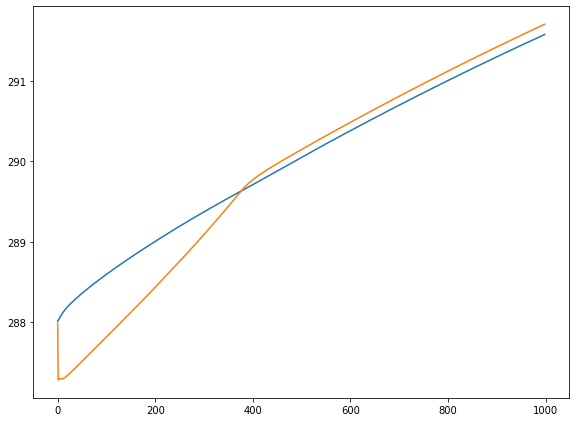

In [4]:
fig, ax = plt.subplots(figsize=(1.5*6.4, 1.5*4.8))
T_sfc_rec = np.array(T_sfc_1[1:1000])
T_low_rec = np.array(T_low_1[1:1000])
plt.plot(T_sfc_rec)
plt.plot(T_low_rec)
plt.show()

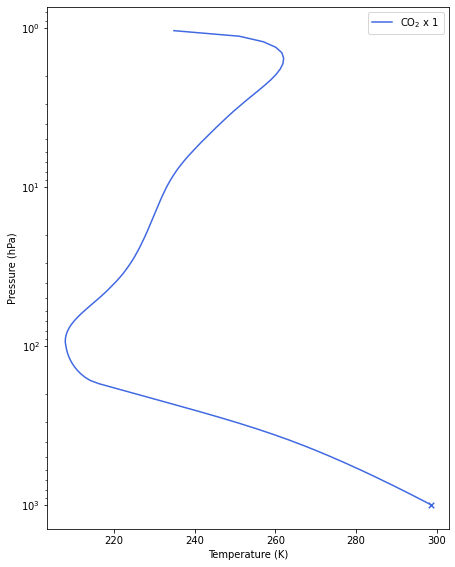

In [5]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))


ax.plot(T_atm_1, atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(T_sfc_1[-1], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()